# Dự đoán Bệnh Tim - EDA & Tiền xử lý

Phân tích khám phá dữ liệu (EDA) và tiền xử lý dữ liệu bệnh tim sử dụng PySpark.

##  1. Import Libraries & Khởi tạo Spark

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Thiết lập PySpark
if 'SPARK_HOME' in os.environ:
    del os.environ['SPARK_HOME']
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, mean, stddev, sqrt, lit, round as spark_round
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Initialize Spark
spark = SparkSession.builder.appName('HeartDiseaseEDA').getOrCreate()
print('Đã tạo Spark Session thành công!')
spark

Đã tạo Spark Session thành công!


##  2. Tải Dữ liệu

In [2]:
# Tải dataset
df = spark.read.csv('../data/raw/cardio_train.csv', header=True, sep=',', inferSchema=True)
print(f'Dataset Shape: {df.count()} rows x {len(df.columns)} columns')
df.show(10)

Dataset Shape: 70000 rows x 13 columns
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 13

##  3. Tổng quan Dữ liệu

In [3]:
# Cấu trúc dữ liệu
print('Cấu trúc dữ liệu:')
df.printSchema()

Cấu trúc dữ liệu:
root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



In [4]:
# Mô tả các đặc trưng
feature_info = {
    'id': 'Mã định danh duy nhất',
    'age': 'Tuổi (tính theo ngày)',
    'gender': 'Giới tính (1: Nữ, 2: Nam)',
    'height': 'Chiều cao (cm)',
    'weight': 'Cân nặng (kg)',
    'ap_hi': 'Huyết áp tâm thu',
    'ap_lo': 'Huyết áp tâm trương',
    'cholesterol': 'Cholesterol (1: Bình thường, 2: Cao hơn bình thường, 3: Rất cao)',
    'gluc': 'Glucose (1: Bình thường, 2: Cao hơn bình thường, 3: Rất cao)',
    'smoke': 'Hút thuốc (0: Không, 1: Có)',
    'alco': 'Uống rượu (0: Không, 1: Có)',
    'active': 'Hoạt động thể chất (0: Không, 1: Có)',
    'cardio': 'Biến mục tiêu: Bệnh tim (0: Không, 1: Có)'
}
print('Mô tả các đặc trưng:')
for feat, desc in feature_info.items():
    print(f'  • {feat}: {desc}')

Mô tả các đặc trưng:
  • id: Mã định danh duy nhất
  • age: Tuổi (tính theo ngày)
  • gender: Giới tính (1: Nữ, 2: Nam)
  • height: Chiều cao (cm)
  • weight: Cân nặng (kg)
  • ap_hi: Huyết áp tâm thu
  • ap_lo: Huyết áp tâm trương
  • cholesterol: Cholesterol (1: Bình thường, 2: Cao hơn bình thường, 3: Rất cao)
  • gluc: Glucose (1: Bình thường, 2: Cao hơn bình thường, 3: Rất cao)
  • smoke: Hút thuốc (0: Không, 1: Có)
  • alco: Uống rượu (0: Không, 1: Có)
  • active: Hoạt động thể chất (0: Không, 1: Có)
  • cardio: Biến mục tiêu: Bệnh tim (0: Không, 1: Có)


In [5]:
from pyspark.sql import functions as F

# Summary statistics - Display as formatted table with 12 parameters
print('Thống kê mô tả:')

# Get numeric columns (exclude 'id')
numeric_cols = [field.name for field in df.schema.fields if field.name != 'id']

# Get total count
total_count = df.count()

# Calculate all statistics
stats_list = []

for col_name in numeric_cols:
    # Count non-null values
    col_count = df.filter(F.col(col_name).isNotNull()).count()

    # Basic stats
    basic_stats = df.select(
        F.min(col_name).alias('Min'),
        F.max(col_name).alias('Max'),
        F.mean(col_name).alias('Mean'),
        F.stddev(col_name).alias('Std'),
        F.variance(col_name).alias('Var')
    ).collect()[0]

    # Percentiles: Q1 (25%), Q2/Median (50%), Q3 (75%)
    percentiles = df.approxQuantile(col_name, [0.25, 0.5, 0.75], 0.01)
    Q1, Q2, Q3 = percentiles[0], percentiles[1], percentiles[2]
    IQR = Q3 - Q1

    # Mode (most frequent value)
    mode_row = df.groupBy(col_name).count().orderBy(F.desc('count')).first()
    mode_val = mode_row[0] if mode_row else None

    stats_list.append({
        'Column': col_name,
        'Số lượng': col_count,
        'Min': round(float(basic_stats['Min']), 2) if basic_stats['Min'] is not None else None,
        'Max': round(float(basic_stats['Max']), 2) if basic_stats['Max'] is not None else None,
        'Mode': round(float(mode_val), 2) if mode_val is not None else None,
        'Mean': round(float(basic_stats['Mean']), 2) if basic_stats['Mean'] is not None else None,
        'Median': round(Q2, 2),
        'Q1': round(Q1, 2),
        'Q2': round(Q2, 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'Std': round(float(basic_stats['Std']), 2) if basic_stats['Std'] is not None else None,
        'Var': round(float(basic_stats['Var']), 2) if basic_stats['Var'] is not None else None
    })

# Convert to Pandas DataFrame for display
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df.set_index('Column')

# Reorder columns for better readability
column_order = ['Số lượng', 'Min', 'Max', 'Mode', 'Mean', 'Median', 'Q1', 'Q2', 'Q3', 'IQR', 'Std', 'Var']
stats_df = stats_df[column_order]

# Display the formatted table
display(stats_df)

Thống kê mô tả:


,Số lượng,Min,Max,Mode,Mean,Median,Q1,Q2,Q3,IQR,Std,Var
Column,,,,,,,,,,,,
age,70000,10798.0,23713.0,19741.0,19468.87,19699.0,17578.0,19699.0,21316.0,3738.0,2467.25,6087330.79
gender,70000,1.0,2.0,1.0,1.35,1.0,1.0,1.0,2.0,1.0,0.48,0.23
height,70000,55.0,250.0,165.0,164.36,165.0,159.0,165.0,170.0,11.0,8.21,67.41
weight,70000,10.0,200.0,65.0,74.21,72.0,65.0,72.0,82.0,17.0,14.40,207.24
ap_hi,70000,-150.0,16020.0,120.0,128.82,120.0,120.0,120.0,140.0,20.0,154.01,23719.52
ap_lo,70000,-70.0,11000.0,80.0,96.63,80.0,80.0,80.0,90.0,10.0,188.47,35521.89
cholesterol,70000,1.0,3.0,1.0,1.37,1.0,1.0,1.0,1.0,0.0,0.68,0.46
gluc,70000,1.0,3.0,1.0,1.23,1.0,1.0,1.0,1.0,0.0,0.57,0.33
smoke,70000,0.0,1.0,0.0,0.09,0.0,0.0,0.0,0.0,0.0,0.28,0.08


##  3.5. Kiểm tra Chất lượng & Tính hợp lý của Dữ liệu


 KIỂM TRA TÍNH HỢP LÝ CỦA DỮ LIỆU

 Tiêu chí kiểm tra:
 • Chiều cao: 140-200 cm
 • Cân nặng: 40-150 kg
 • Tuổi: 30-70 năm
 • Huyết áp: ap_hi > ap_lo
 • ap_hi: 80-200 mmHg
 • ap_lo: 60-140 mmHg

 Số lượng bản ghi không hợp lý:
 • Chiều cao < 140cm: 152 (0.22%)
 • Chiều cao > 200cm: 2 (0.00%)
 • Cân nặng < 40kg: 52 (0.07%)
 • Cân nặng > 150kg: 59 (0.08%)
 • Tuổi < 30 năm: 3 (0.00%)
 • ap_hi ≤ ap_lo: 1,236 (1.77%)
 • ap_hi < 80: 207 (0.30%)
 • ap_hi > 200: 100 (0.14%)
 • ap_lo < 60: 175 (0.25%)
 • ap_lo > 140: 983 (1.40%)

 Tổng số vi phạm: 2,969

 Đang lọc dữ liệu...


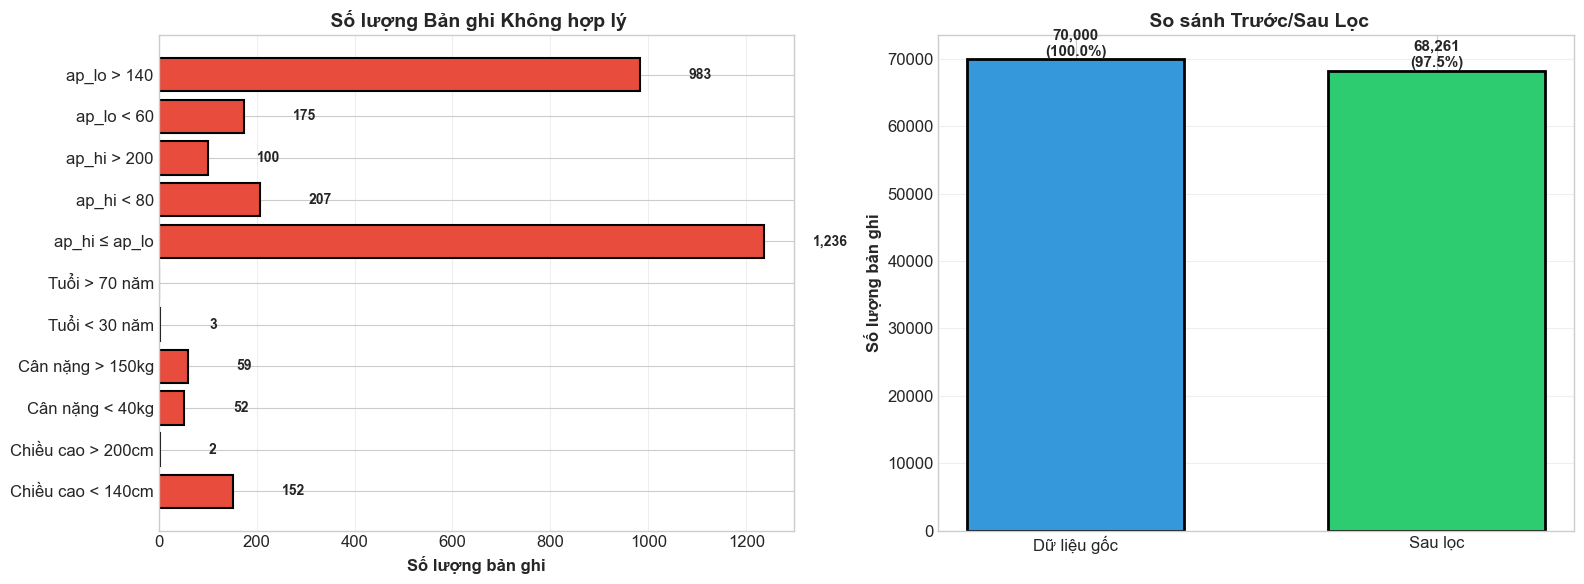


 KẾT QUẢ:
 • Dữ liệu gốc: 70,000 bản ghi
 • Đã loại bỏ: 1,739 bản ghi (2.48%)
 • Còn lại: 68,261 bản ghi (97.52%)

 Biểu đồ đã lưu: ../results/00_data_validation.png

 Đã cập nhật DataFrame với dữ liệu sạch


In [6]:
# Kiểm tra tính hợp lý của dữ liệu
print(' KIỂM TRA TÍNH HỢP LÝ CỦA DỮ LIỆU')
print('=' * 70)

# Chuyển sang pandas để xử lý
pdf_check = df.toPandas()
pdf_check['age_years'] = pdf_check['age'] / 365

# Định nghĩa các tiêu chí hợp lý
print('\n Tiêu chí kiểm tra:')
print(' • Chiều cao: 140-200 cm')
print(' • Cân nặng: 40-150 kg')
print(' • Tuổi: 30-70 năm')
print(' • Huyết áp: ap_hi > ap_lo')
print(' • ap_hi: 80-200 mmHg')
print(' • ap_lo: 60-140 mmHg')

# Đếm số lượng invalid records
invalid_counts = {
    'Chiều cao < 140cm': (pdf_check['height'] < 140).sum(),
    'Chiều cao > 200cm': (pdf_check['height'] > 200).sum(),
    'Cân nặng < 40kg': (pdf_check['weight'] < 40).sum(),
    'Cân nặng > 150kg': (pdf_check['weight'] > 150).sum(),
    'Tuổi < 30 năm': (pdf_check['age_years'] < 30).sum(),
    'Tuổi > 70 năm': (pdf_check['age_years'] > 70).sum(),
    'ap_hi ≤ ap_lo': (pdf_check['ap_hi'] <= pdf_check['ap_lo']).sum(),
    'ap_hi < 80': (pdf_check['ap_hi'] < 80).sum(),
    'ap_hi > 200': (pdf_check['ap_hi'] > 200).sum(),
    'ap_lo < 60': (pdf_check['ap_lo'] < 60).sum(),
    'ap_lo > 140': (pdf_check['ap_lo'] > 140).sum(),
}

# Hiển thị kết quả
print('\n Số lượng bản ghi không hợp lý:')
total_violations = 0
for criteria, count_val in invalid_counts.items():
    if count_val > 0:
        pct = count_val/len(pdf_check)*100
        print(f' • {criteria}: {count_val:,} ({pct:.2f}%)')
        total_violations += count_val

print(f'\n Tổng số vi phạm: {total_violations:,}')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart của invalid counts
criteria_names = list(invalid_counts.keys())
counts = list(invalid_counts.values())
colors = ['#e74c3c' if c > 0 else '#95a5a6' for c in counts]

axes[0].barh(criteria_names, counts, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Số lượng bản ghi', fontsize=12, fontweight='bold')
axes[0].set_title(' Số lượng Bản ghi Không hợp lý', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

for i, v in enumerate(counts):
    if v > 0:
        axes[0].text(v + 100, i, f'{v:,}', va='center', fontsize=10, fontweight='bold')

# Loại bỏ invalid data
print('\n Đang lọc dữ liệu...')
original_count = len(pdf_check)

pdf_clean = pdf_check[
    (pdf_check['height'] >= 140) & (pdf_check['height'] <= 200) &
    (pdf_check['weight'] >= 40) & (pdf_check['weight'] <= 150) &
    (pdf_check['age_years'] >= 30) & (pdf_check['age_years'] <= 70) &
    (pdf_check['ap_hi'] > pdf_check['ap_lo']) &
    (pdf_check['ap_hi'] >= 80) & (pdf_check['ap_hi'] <= 200) &
    (pdf_check['ap_lo'] >= 60) & (pdf_check['ap_lo'] <= 140)
].copy()

removed_count = original_count - len(pdf_clean)
retained_pct = len(pdf_clean) / original_count * 100

# Before/After comparison
stages = ['Dữ liệu gốc', 'Sau lọc']
record_counts = [original_count, len(pdf_clean)]
colors_bar = ['#3498db', '#2ecc71']

axes[1].bar(stages, record_counts, color=colors_bar, edgecolor='black', width=0.6, linewidth=2)
axes[1].set_ylabel('Số lượng bản ghi', fontsize=12, fontweight='bold')
axes[1].set_title(' So sánh Trước/Sau Lọc', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(record_counts):
    pct = v/original_count*100
    axes[1].text(i, v + 500, f'{v:,}\n({pct:.1f}%)',
                ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/00_data_validation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n KẾT QUẢ:')
print(f' • Dữ liệu gốc: {original_count:,} bản ghi')
print(f' • Đã loại bỏ: {removed_count:,} bản ghi ({removed_count/original_count*100:.2f}%)')
print(f' • Còn lại: {len(pdf_clean):,} bản ghi ({retained_pct:.2f}%)')
print(f'\n Biểu đồ đã lưu: ../results/00_data_validation.png')

# Cập nhật df với dữ liệu đã clean
df = spark.createDataFrame(pdf_clean)
pdf = pdf_clean.copy()
print('\n Đã cập nhật DataFrame với dữ liệu sạch')



##  4. Kiểm tra Giá trị Thiếu & Trùng lặp

In [7]:
# Kiểm tra giá trị null
print(' Kiểm tra Giá trị Thiếu:')
missing_df = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
missing_df.show()

 Kiểm tra Giá trị Thiếu:
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+
| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|age_years|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+
|  0|  0|     0|     0|     0|    0|    0|          0|   0|    0|   0|     0|     0|        0|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+



In [8]:
# Kiểm tra trùng lặp
total_rows = df.count()
unique_rows = df.dropDuplicates().count()
duplicates = total_rows - unique_rows
print(f' Total rows: {total_rows}')
print(f' Unique rows: {unique_rows}')
print(f' Duplicate rows: {duplicates}')

# Drop duplicates
df = df.dropDuplicates()
print(f' After dropping duplicates: {df.count()} rows')

 Total rows: 68261
 Unique rows: 68261
 Duplicate rows: 0
 After dropping duplicates: 68261 rows


##  5. Phân tích Biến Mục tiêu

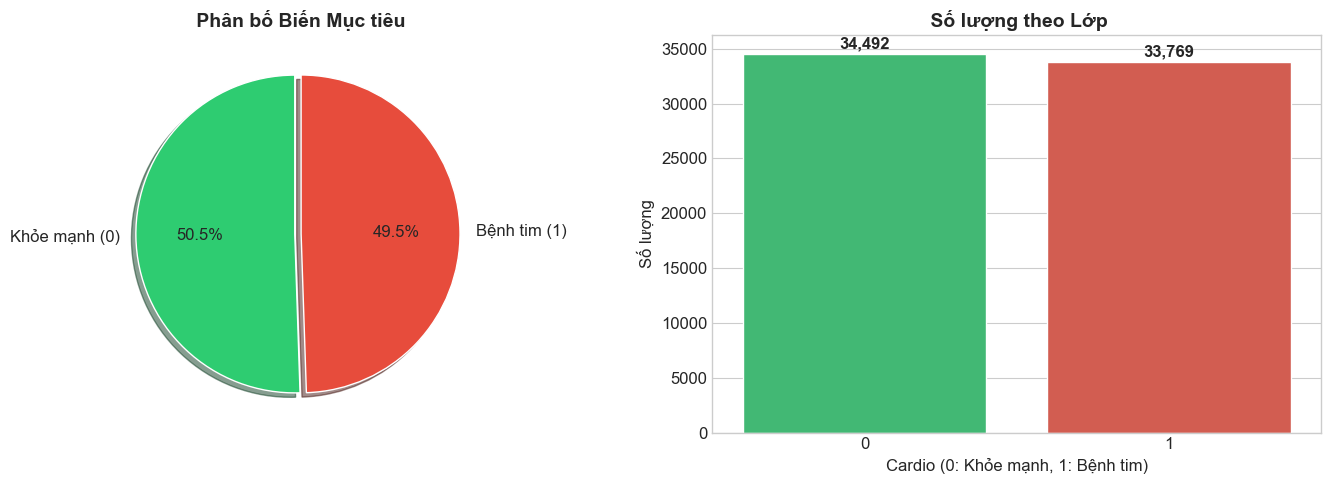

 Biểu đồ đã lưu vào ../results/01_target_distribution.png


In [9]:
# Chuyển sang pandas để visualization
pdf = df.toPandas()

# Phân bố biến mục tiêu
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
target_counts = pdf['cardio'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(target_counts, labels=['Khỏe mạnh (0)', 'Bệnh tim (1)'], autopct='%1.1f%%',
            colors=colors, explode=(0.02, 0.02), shadow=True, startangle=90)
axes[0].set_title(' Phân bố Biến Mục tiêu', fontsize=14, fontweight='bold')

# Bar chart
sns.countplot(x='cardio', data=pdf, ax=axes[1], palette=colors)
axes[1].set_xlabel('Cardio (0: Khỏe mạnh, 1: Bệnh tim)')
axes[1].set_ylabel('Số lượng')
axes[1].set_title(' Số lượng theo Lớp', fontsize=14, fontweight='bold')
for i, v in enumerate(target_counts.sort_index()):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/01_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f' Biểu đồ đã lưu vào ../results/01_target_distribution.png')

## ⚖️ 5.5. Phân tích Cân bằng Class


 PHÂN TÍCH CÂN BẰNG CLASS

 Phân bố Class:
 • Class 0 (Khỏe mạnh): 34,492 (50.53%)
 • Class 1 (Bệnh tim): 33,769 (49.47%)
 • Tổng: 68,261

 Imbalance Ratio: 1.02:1

 CÂN BẰNG TỐT
 Khuyến nghị: Dữ liệu cân bằng, không cần xử lý đặc biệt


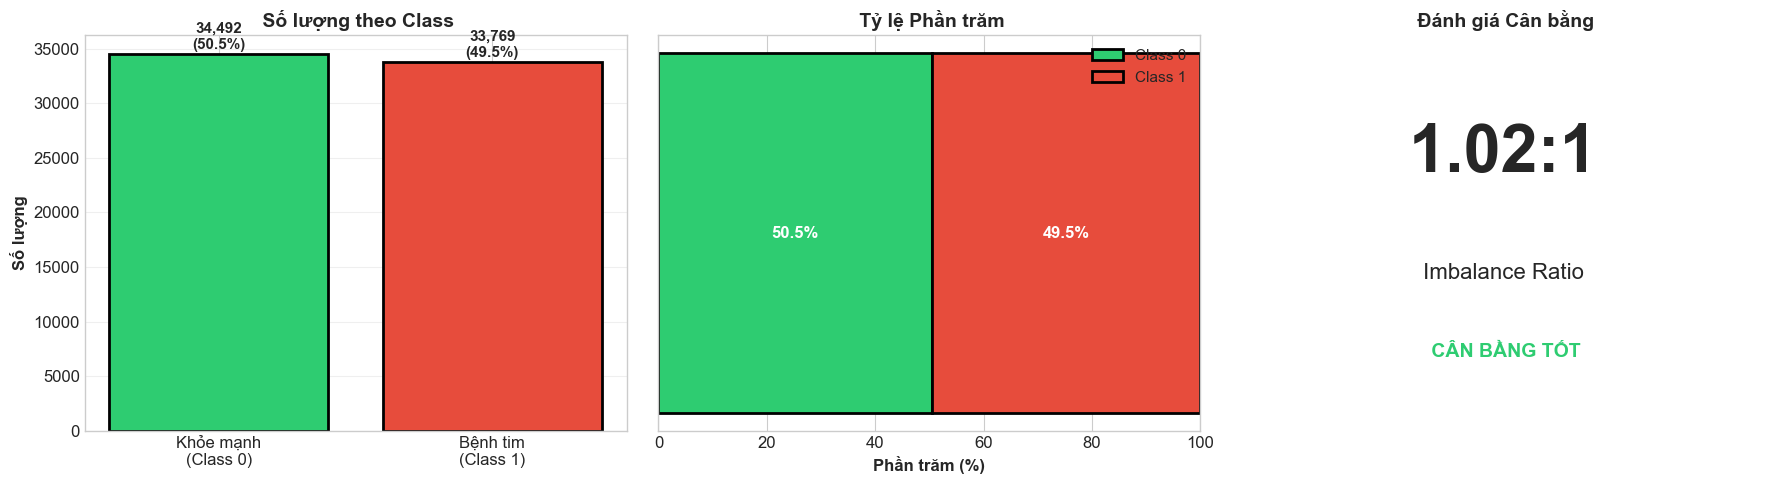


 Biểu đồ đã lưu: ../results/05_5_class_imbalance.png


In [10]:
# Phân tích class imbalance
print(' PHÂN TÍCH CÂN BẰNG CLASS')
print('=' * 70)

# Đếm số lượng mỗi class
class_counts = pdf['cardio'].value_counts().sort_index()
class_0 = class_counts[0]
class_1 = class_counts[1]
total = len(pdf)

# Tính tỷ lệ
pct_0 = class_0 / total * 100
pct_1 = class_1 / total * 100
imbalance_ratio = max(class_0, class_1) / min(class_0, class_1)

print(f'\n Phân bố Class:')
print(f' • Class 0 (Khỏe mạnh): {class_0:,} ({pct_0:.2f}%)')
print(f' • Class 1 (Bệnh tim): {class_1:,} ({pct_1:.2f}%)')
print(f' • Tổng: {total:,}')
print(f'\n Imbalance Ratio: {imbalance_ratio:.2f}:1')

# Đánh giá mức độ imbalance
if imbalance_ratio < 1.5:
    status = ' CÂN BẰNG TỐT'
    color_status = '#2ecc71'
    recommendation = 'Dữ liệu cân bằng, không cần xử lý đặc biệt'
elif imbalance_ratio < 3:
    status = ' HƠI MẤT CÂN BẰNG'
    color_status = '#f39c12'
    recommendation = 'Có thể cân nhắc class weights trong modeling'
else:
    status = ' MẤT CÂN BẰNG NGHIÊM TRỌNG'
    color_status = '#e74c3c'
    recommendation = 'Nên sử dụng SMOTE/oversampling trong notebook 02'

print(f'\n{status}')
print(f' Khuyến nghị: {recommendation}')

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Bar chart với số lượng
axes[0].bar(['Khỏe mạnh\n(Class 0)', 'Bệnh tim\n(Class 1)'],
           [class_0, class_1],
           color=['#2ecc71', '#e74c3c'],
           edgecolor='black',
           linewidth=2)
axes[0].set_ylabel('Số lượng', fontsize=12, fontweight='bold')
axes[0].set_title(' Số lượng theo Class', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, (v, p) in enumerate(zip([class_0, class_1], [pct_0, pct_1])):
    axes[0].text(i, v + 500, f'{v:,}\n({p:.1f}%)',
                ha='center', fontsize=11, fontweight='bold')

# 2. Percentage bar chart
axes[1].barh([''], [pct_0], color='#2ecc71', edgecolor='black', linewidth=2, label='Class 0')
axes[1].barh([''], [pct_1], left=[pct_0], color='#e74c3c', edgecolor='black', linewidth=2, label='Class 1')
axes[1].set_xlabel('Phần trăm (%)', fontsize=12, fontweight='bold')
axes[1].set_title(' Tỷ lệ Phần trăm', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11)
axes[1].set_xlim(0, 100)

# Add percentage labels
axes[1].text(pct_0/2, 0, f'{pct_0:.1f}%', ha='center', va='center',
            fontsize=12, fontweight='bold', color='white')
axes[1].text(pct_0 + pct_1/2, 0, f'{pct_1:.1f}%', ha='center', va='center',
            fontsize=12, fontweight='bold', color='white')

# 3. Imbalance ratio gauge
axes[2].text(0.5, 0.7, f'{imbalance_ratio:.2f}:1',
            ha='center', va='center', fontsize=48, fontweight='bold',
            transform=axes[2].transAxes)
axes[2].text(0.5, 0.4, 'Imbalance Ratio',
            ha='center', va='center', fontsize=16,
            transform=axes[2].transAxes)
axes[2].text(0.5, 0.2, status,
            ha='center', va='center', fontsize=14, fontweight='bold',
            color=color_status, transform=axes[2].transAxes)
axes[2].axis('off')
axes[2].set_title(' Đánh giá Cân bằng', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/05_5_class_imbalance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n Biểu đồ đã lưu: ../results/05_5_class_imbalance.png')


##  6. Phân bố Đặc trưng Số

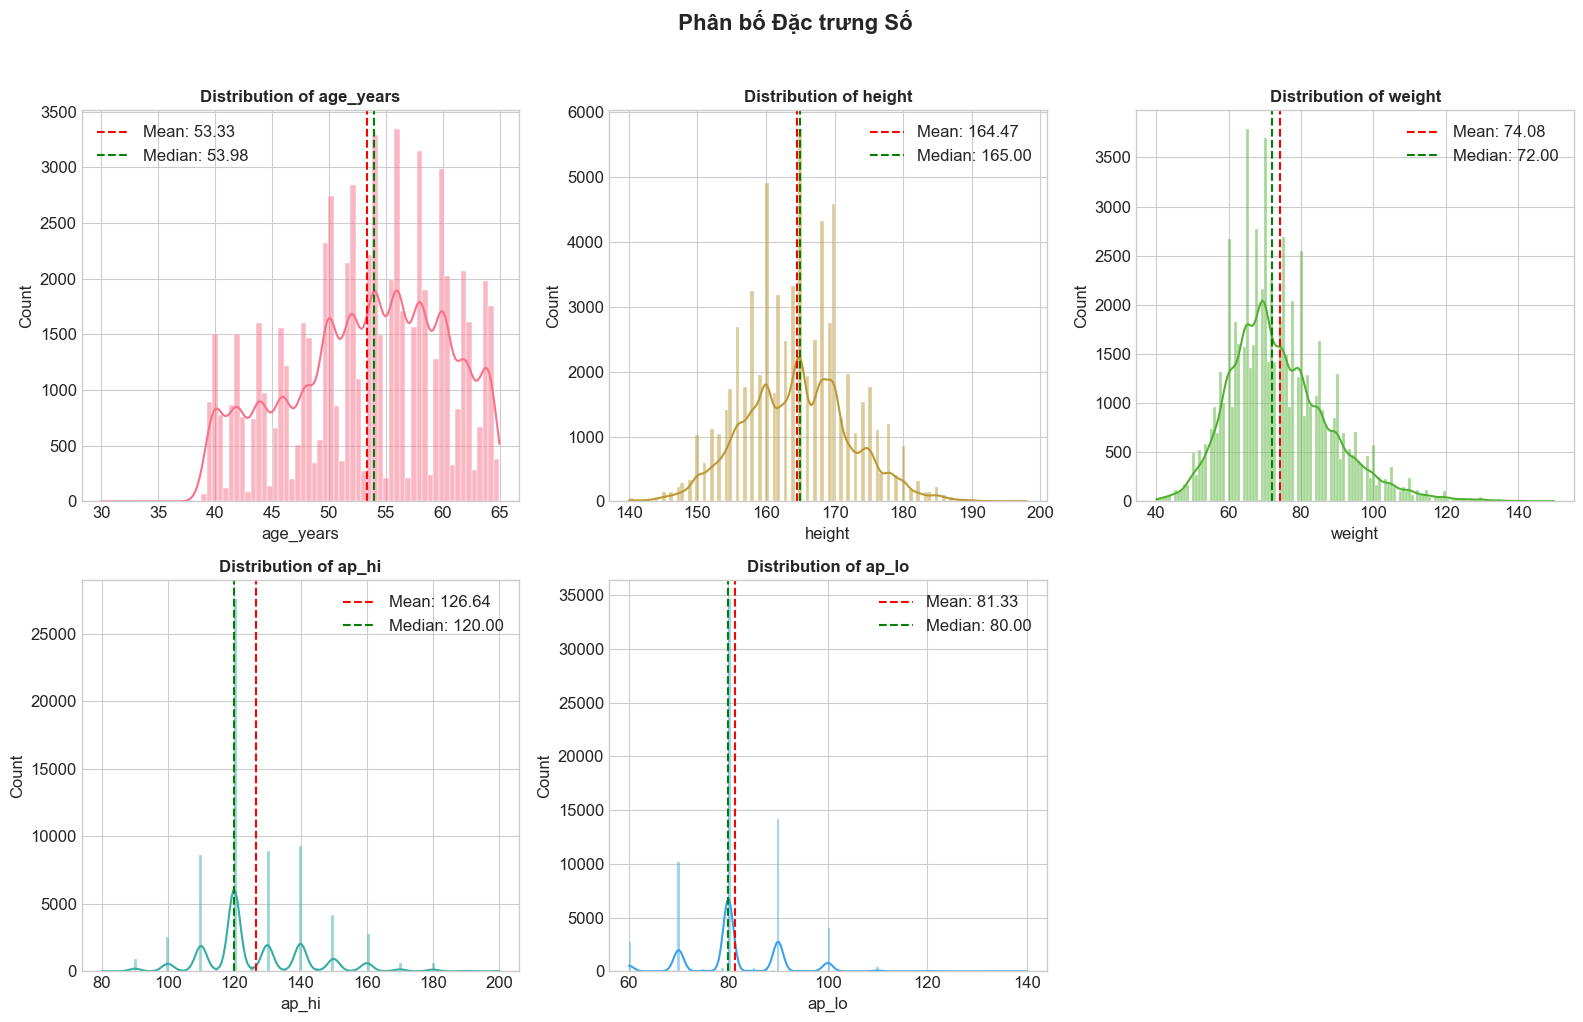

 Biểu đồ đã lưu vào ../results/02_numeric_distributions.png


In [11]:
# Chuyển đổi tuổi sang năm
pdf['age_years'] = pdf['age'] / 365

# Histogram các đặc trưng số
numeric_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col_name in enumerate(numeric_cols):
    sns.histplot(pdf[col_name], kde=True, ax=axes[idx], color=sns.color_palette('husl')[idx])
    axes[idx].set_title(f'Distribution of {col_name}', fontsize=12, fontweight='bold')
    axes[idx].axvline(pdf[col_name].mean(), color='red', linestyle='--', label=f'Mean: {pdf[col_name].mean():.2f}')
    axes[idx].axvline(pdf[col_name].median(), color='green', linestyle='--', label=f'Median: {pdf[col_name].median():.2f}')
    axes[idx].legend()

axes[5].axis('off')
plt.suptitle(' Phân bố Đặc trưng Số', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/02_numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/02_numeric_distributions.png')

##  6.5. Phân tích Skewness & Kurtosis


 PHÂN TÍCH SKEWNESS & KURTOSIS

 Kết quả phân tích:
  Feature  Skewness Skew_Type  Kurtosis          Kurt_Type
age_years -0.304379 Gần chuẩn -0.828443  Platykurtic (tẹt)
   height  0.151579 Gần chuẩn  0.064147 Mesokurtic (chuẩn)
   weight  0.862752 Lệch phải  1.363624 Leptokurtic (nhọn)
    ap_hi  0.854719 Lệch phải  1.302706 Leptokurtic (nhọn)
    ap_lo  0.321530 Gần chuẩn  1.276313 Leptokurtic (nhọn)

📖 Giải thích:
 Skewness:
 • -0.5 đến 0.5: Phân phối gần chuẩn
 • > 0.5: Lệch phải (đuôi dài bên phải)
 • < -0.5: Lệch trái (đuôi dài bên trái)
 Kurtosis:
 • -0.5 đến 0.5: Mesokurtic (giống phân phối chuẩn)
 • > 0.5: Leptokurtic (nhọn hơn, nhiều outliers)
 • < -0.5: Platykurtic (tẹt hơn, ít outliers)


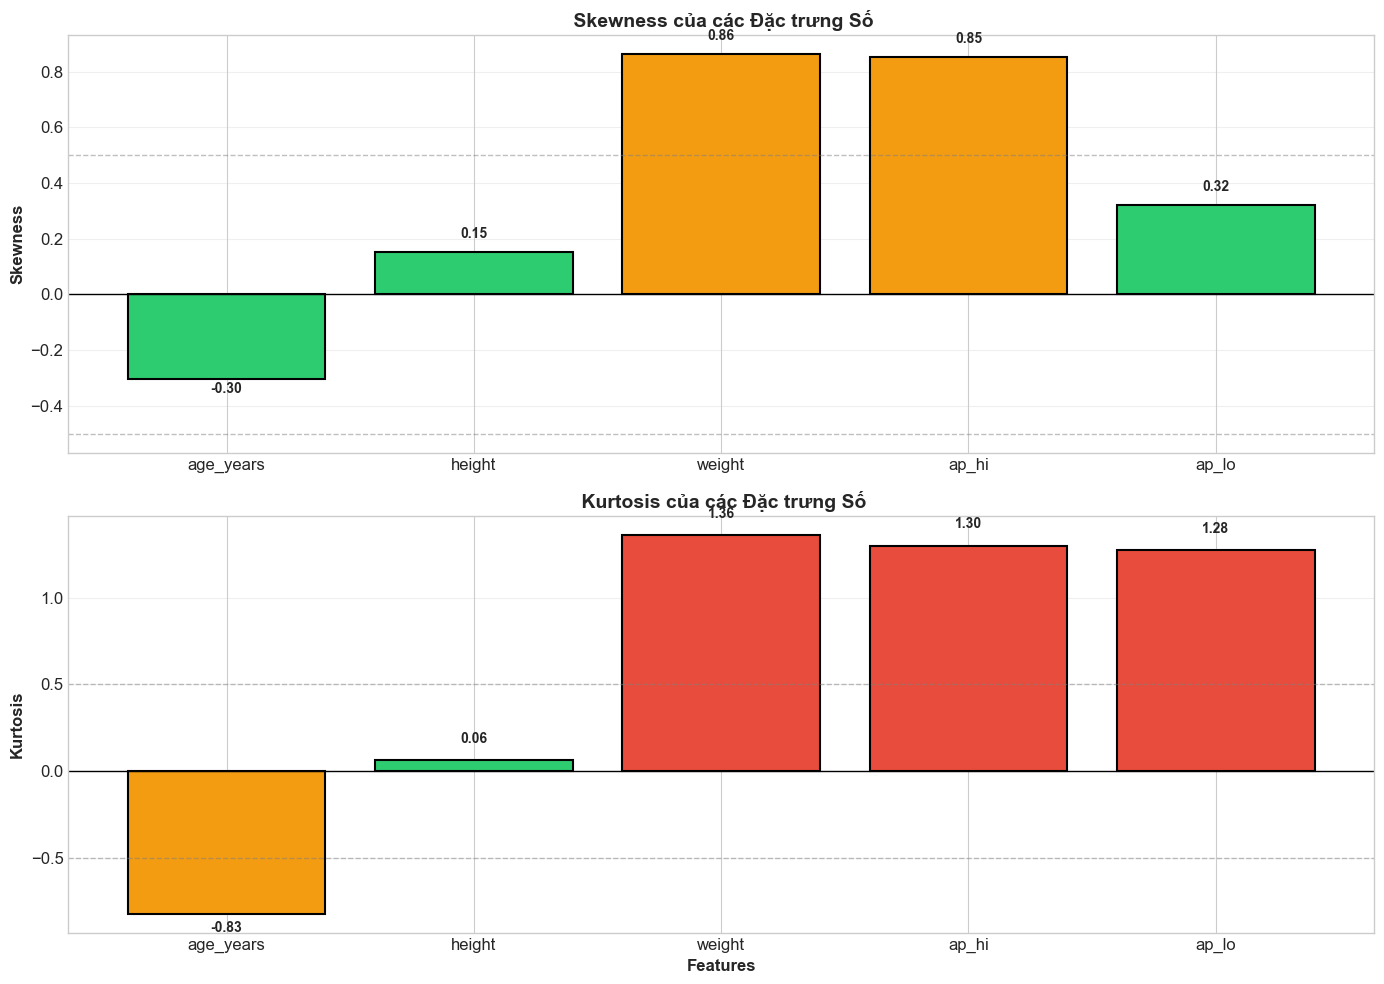


 Biểu đồ đã lưu: ../results/06_5_skewness_kurtosis.png

 KẾT LUẬN:
 • Tất cả features có phân phối tương đối tốt


In [12]:
# Phân tích Skewness & Kurtosis
print(' PHÂN TÍCH SKEWNESS & KURTOSIS')
print('=' * 70)

from scipy import stats

# Các features số để phân tích
numeric_features = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']

# Tính skewness và kurtosis
skew_kurt_data = []
for col in numeric_features:
    skewness = stats.skew(pdf[col])
    kurtosis_val = stats.kurtosis(pdf[col])

    # Phân loại skewness
    if abs(skewness) < 0.5:
        skew_type = 'Gần chuẩn'
    elif skewness > 0:
        skew_type = 'Lệch phải'
    else:
        skew_type = 'Lệch trái'

    # Phân loại kurtosis
    if abs(kurtosis_val) < 0.5:
        kurt_type = 'Mesokurtic (chuẩn)'
    elif kurtosis_val > 0:
        kurt_type = 'Leptokurtic (nhọn)'
    else:
        kurt_type = 'Platykurtic (tẹt)'

    skew_kurt_data.append({
        'Feature': col,
        'Skewness': skewness,
        'Skew_Type': skew_type,
        'Kurtosis': kurtosis_val,
        'Kurt_Type': kurt_type
    })

# Tạo DataFrame
skew_kurt_df = pd.DataFrame(skew_kurt_data)

print('\n Kết quả phân tích:')
print(skew_kurt_df.to_string(index=False))

print('\n📖 Giải thích:')
print(' Skewness:')
print(' • -0.5 đến 0.5: Phân phối gần chuẩn')
print(' • > 0.5: Lệch phải (đuôi dài bên phải)')
print(' • < -0.5: Lệch trái (đuôi dài bên trái)')
print(' Kurtosis:')
print(' • -0.5 đến 0.5: Mesokurtic (giống phân phối chuẩn)')
print(' • > 0.5: Leptokurtic (nhọn hơn, nhiều outliers)')
print(' • < -0.5: Platykurtic (tẹt hơn, ít outliers)')

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Skewness bar chart
features = skew_kurt_df['Feature']
skewness_vals = skew_kurt_df['Skewness']
colors_skew = ['#2ecc71' if abs(s) < 0.5 else '#f39c12' if abs(s) < 1 else '#e74c3c'
               for s in skewness_vals]

axes[0].bar(features, skewness_vals, color=colors_skew, edgecolor='black', linewidth=1.5)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axhline(y=-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_ylabel('Skewness', fontsize=12, fontweight='bold')
axes[0].set_title(' Skewness của các Đặc trưng Số', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(skewness_vals):
    axes[0].text(i, v + 0.05 if v > 0 else v - 0.05, f'{v:.2f}',
                ha='center', fontsize=10, fontweight='bold')

# 2. Kurtosis bar chart
kurtosis_vals = skew_kurt_df['Kurtosis']
colors_kurt = ['#2ecc71' if abs(k) < 0.5 else '#f39c12' if abs(k) < 1 else '#e74c3c'
               for k in kurtosis_vals]

axes[1].bar(features, kurtosis_vals, color=colors_kurt, edgecolor='black', linewidth=1.5)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(y=-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Features', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Kurtosis', fontsize=12, fontweight='bold')
axes[1].set_title(' Kurtosis của các Đặc trưng Số', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(kurtosis_vals):
    axes[1].text(i, v + 0.1 if v > 0 else v - 0.1, f'{v:.2f}',
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/06_5_skewness_kurtosis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n Biểu đồ đã lưu: ../results/06_5_skewness_kurtosis.png')

# Kết luận
print('\n KẾT LUẬN:')
needs_transform = skew_kurt_df[abs(skew_kurt_df['Skewness']) > 1]['Feature'].tolist()
if needs_transform:
    print(f' • Features cần xem xét transform: {", ".join(needs_transform)}')
else:
    print(' • Tất cả features có phân phối tương đối tốt')


##  7. Phân tích Đặc trưng Phân loại

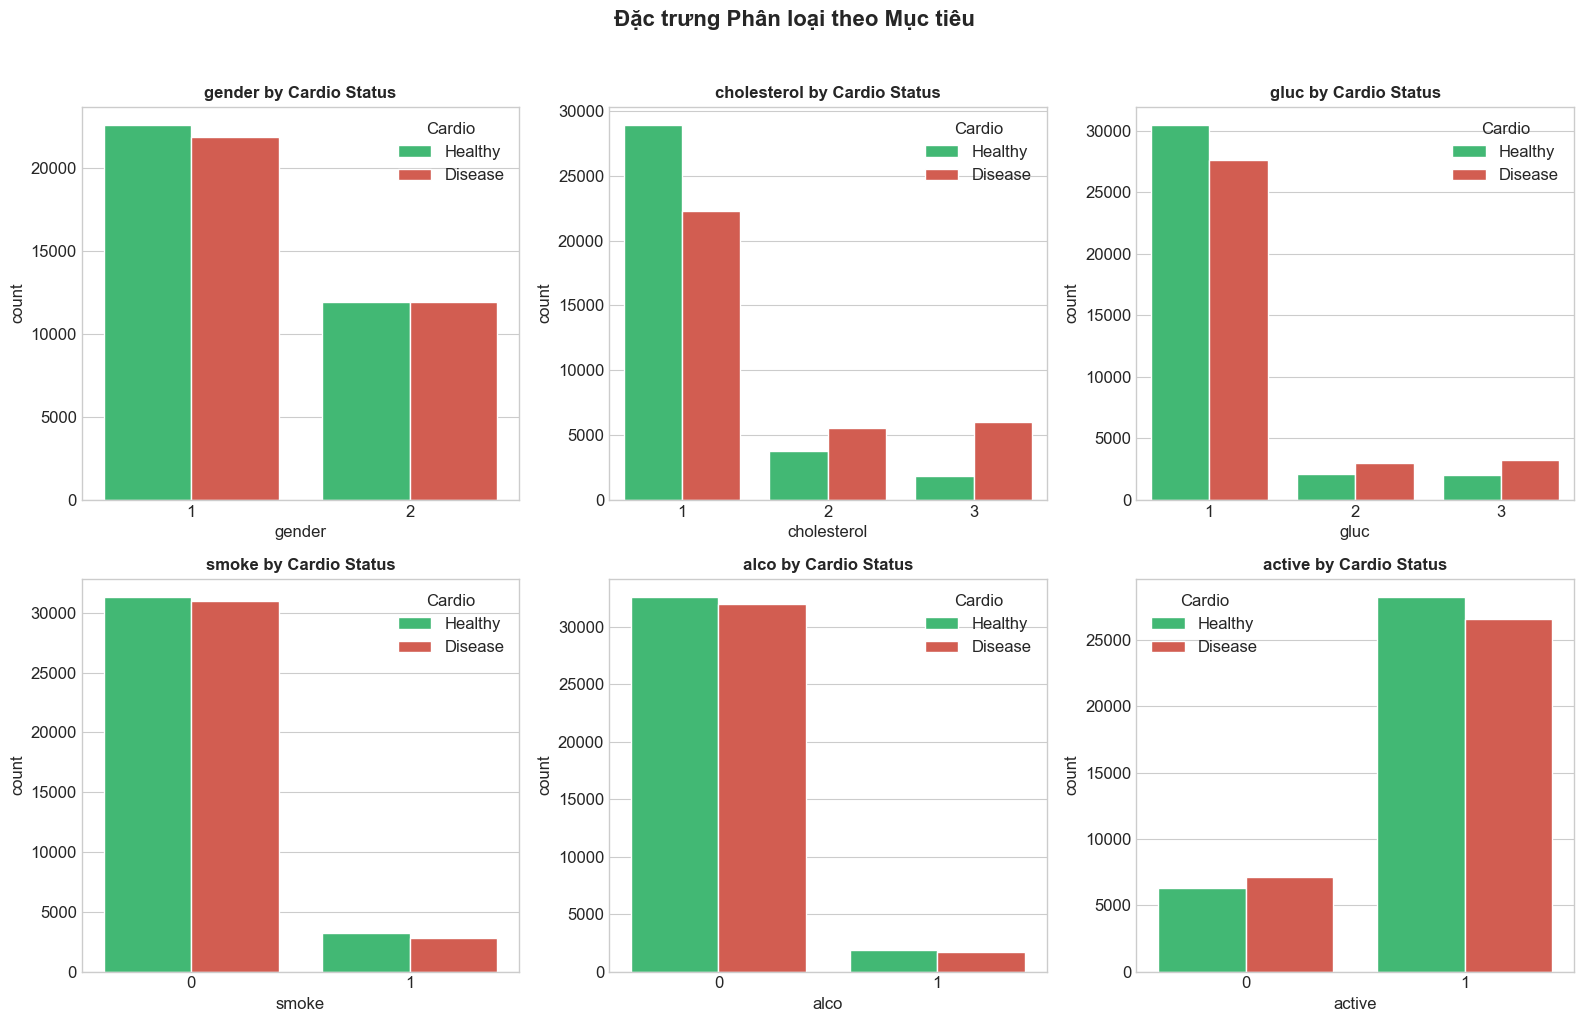

 Biểu đồ đã lưu vào ../results/03_categorical_by_target.png


In [13]:
# Đặc trưng phân loại
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col_name in enumerate(cat_cols):
    sns.countplot(x=col_name, hue='cardio', data=pdf, ax=axes[idx], palette=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{col_name} by Cardio Status', fontsize=12, fontweight='bold')
    axes[idx].legend(title='Cardio', labels=['Healthy', 'Disease'])

plt.suptitle(' Đặc trưng Phân loại theo Mục tiêu', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/03_categorical_by_target.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/03_categorical_by_target.png')

##  8. Phân tích Tương quan

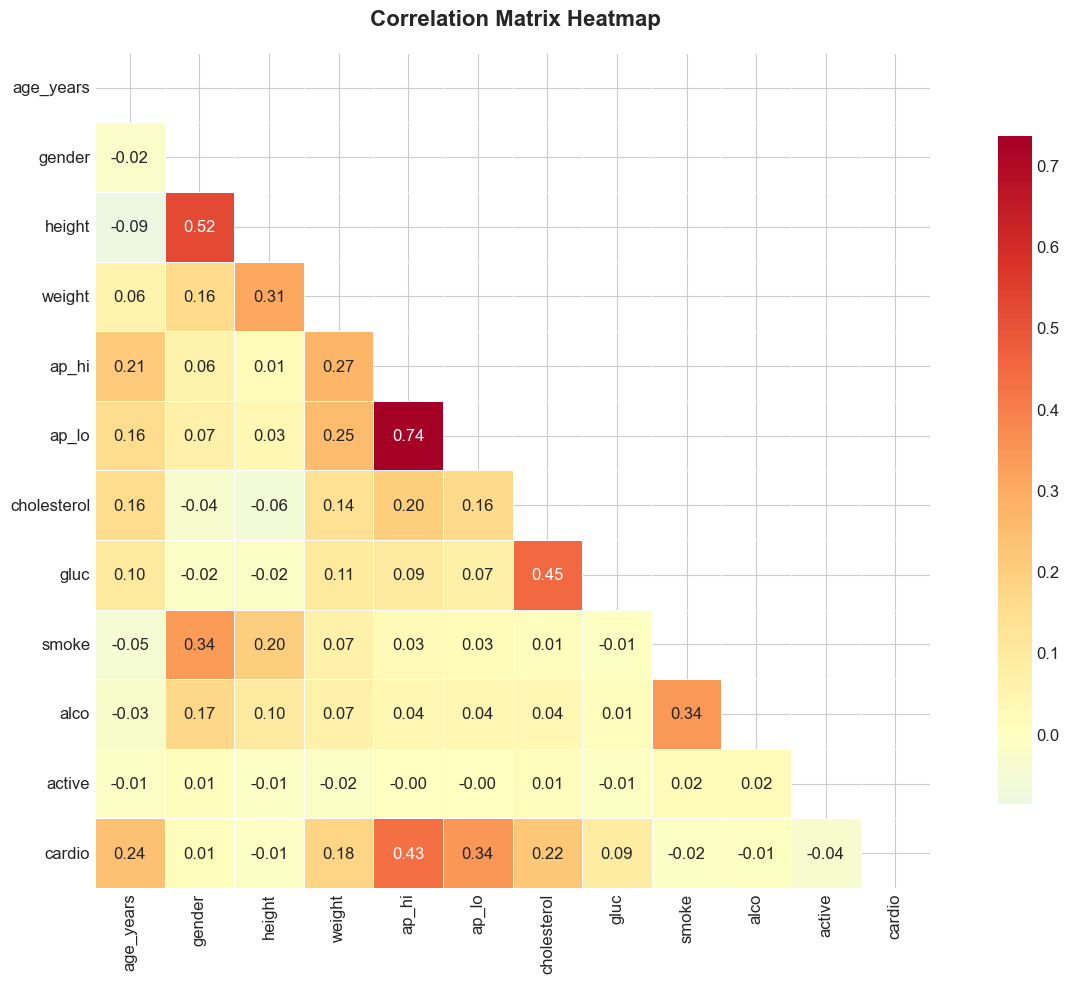

 Biểu đồ đã lưu vào ../results/04_correlation_matrix.png


In [14]:
# Ma trận tương quan
analysis_cols = ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
corr_matrix = pdf[analysis_cols].corr()

fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title(' Correlation Matrix Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/04_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/04_correlation_matrix.png')

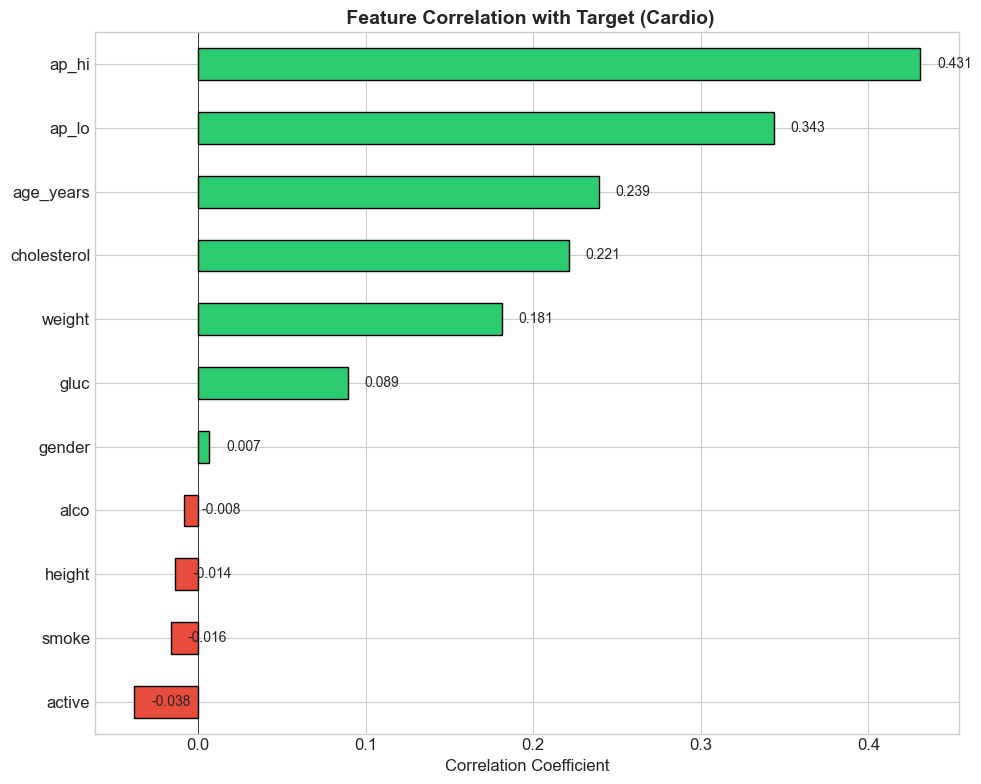

 Biểu đồ đã lưu vào ../results/05_target_correlation.png


In [15]:
# Tương quan đặc trưng với biến mục tiêu
target_corr = corr_matrix['cardio'].drop('cardio').sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in target_corr]
target_corr.plot(kind='barh', color=colors, ax=ax, edgecolor='black')
ax.set_xlabel('Correlation Coefficient')
ax.set_title(' Feature Correlation with Target (Cardio)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
for i, v in enumerate(target_corr):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('../results/05_target_correlation.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/05_target_correlation.png')

##  8.5. Scatter Plots & Phân tích Mối quan hệ


 SCATTER PLOTS & PHÂN TÍCH MỐI QUAN HỆ


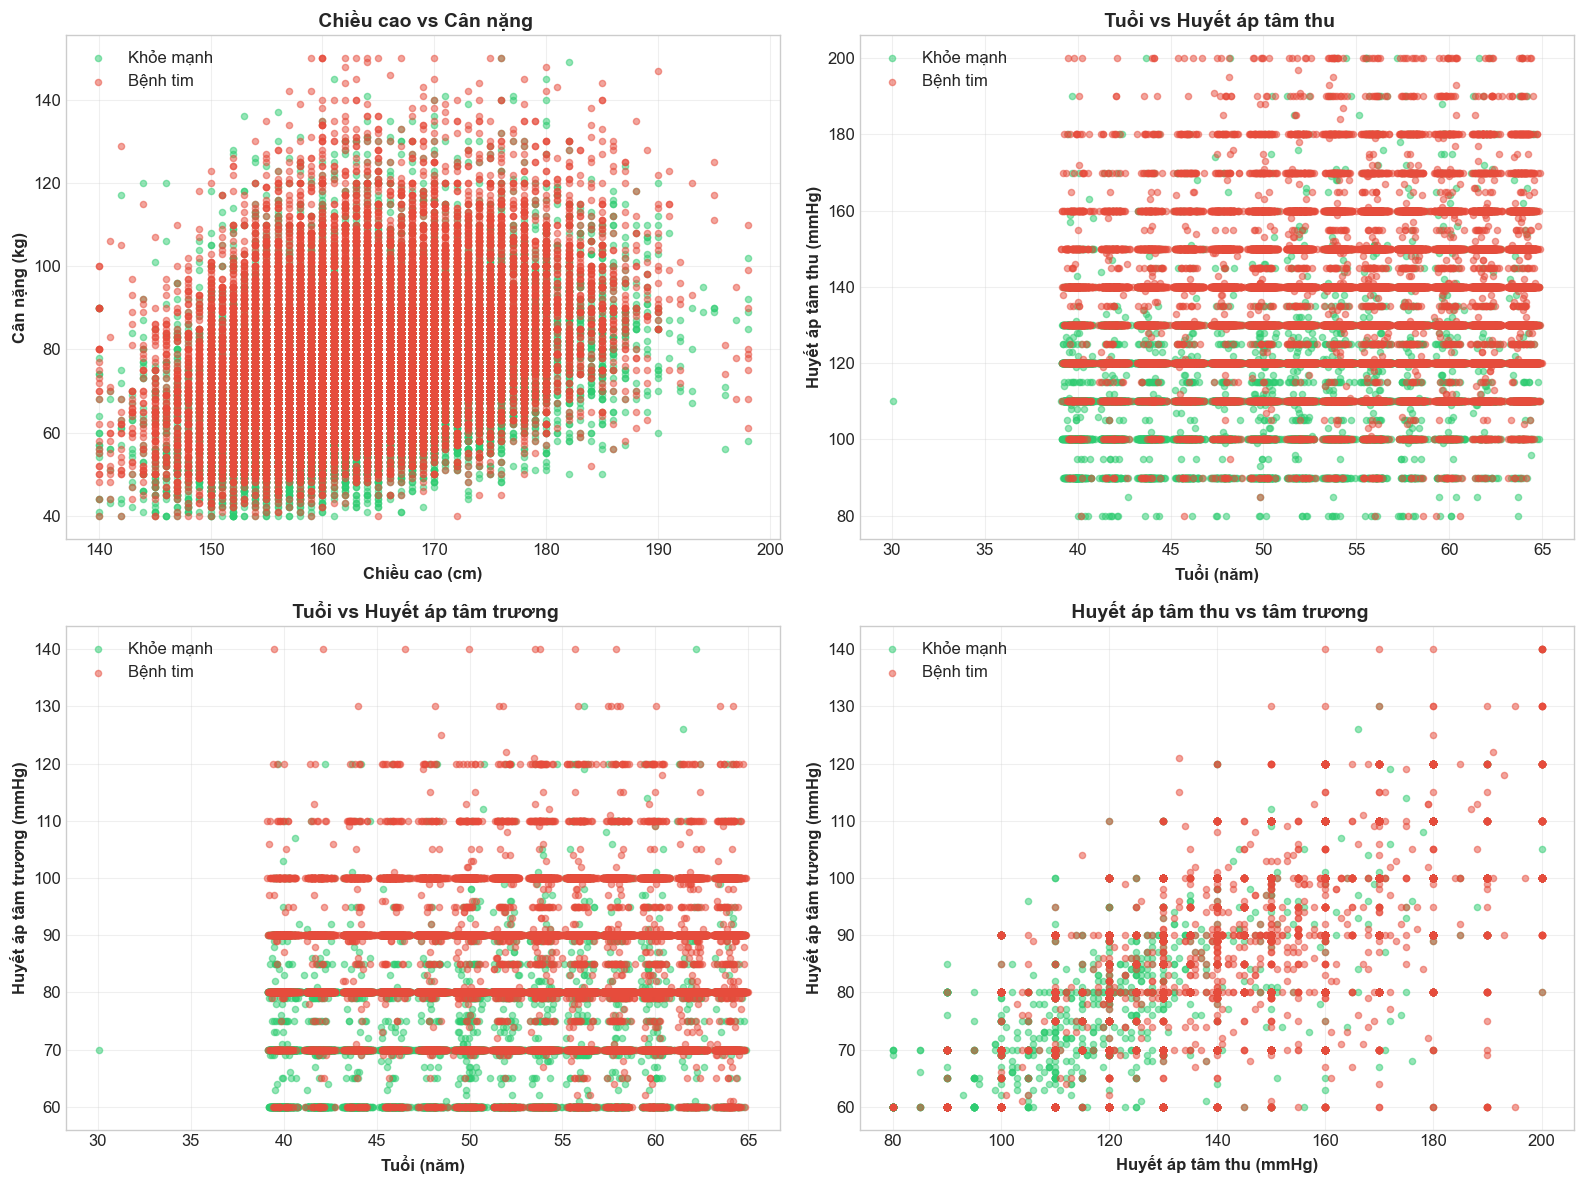


 Biểu đồ đã lưu: ../results/08_5_scatter_plots.png

 THỐNG KÊ THEO NHÓM CARDIO:
       age_years         height        weight          ap_hi         ap_lo  \
            mean median    mean median   mean median    mean median   mean   
cardio                                                                       
0          51.73  52.07  164.57  165.0  71.57   70.0  119.62  120.0  78.17   
1          54.96  55.85  164.36  165.0  76.66   75.0  133.80  130.0  84.55   

               
       median  
cardio         
0        80.0  
1        80.0  

 NHẬN XÉT:
 • So sánh mean/median giữa 2 nhóm để thấy sự khác biệt
 • Nhóm có bệnh tim thường có các chỉ số cao hơn


In [16]:
# Scatter plots và phân tích mối quan hệ
print(' SCATTER PLOTS & PHÂN TÍCH MỐI QUAN HỆ')
print('=' * 70)

# 1. Scatter plots với regression line
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Height vs Weight
for cardio_val, color, label in [(0, '#2ecc71', 'Khỏe mạnh'), (1, '#e74c3c', 'Bệnh tim')]:
    data = pdf[pdf['cardio'] == cardio_val]
    axes[0,0].scatter(data['height'], data['weight'], alpha=0.5, c=color, label=label, s=20)

axes[0,0].set_xlabel('Chiều cao (cm)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Cân nặng (kg)', fontsize=12, fontweight='bold')
axes[0,0].set_title(' Chiều cao vs Cân nặng', fontsize=14, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Age vs ap_hi
for cardio_val, color, label in [(0, '#2ecc71', 'Khỏe mạnh'), (1, '#e74c3c', 'Bệnh tim')]:
    data = pdf[pdf['cardio'] == cardio_val]
    axes[0,1].scatter(data['age_years'], data['ap_hi'], alpha=0.5, c=color, label=label, s=20)

axes[0,1].set_xlabel('Tuổi (năm)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Huyết áp tâm thu (mmHg)', fontsize=12, fontweight='bold')
axes[0,1].set_title(' Tuổi vs Huyết áp tâm thu', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Age vs ap_lo
for cardio_val, color, label in [(0, '#2ecc71', 'Khỏe mạnh'), (1, '#e74c3c', 'Bệnh tim')]:
    data = pdf[pdf['cardio'] == cardio_val]
    axes[1,0].scatter(data['age_years'], data['ap_lo'], alpha=0.5, c=color, label=label, s=20)

axes[1,0].set_xlabel('Tuổi (năm)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Huyết áp tâm trương (mmHg)', fontsize=12, fontweight='bold')
axes[1,0].set_title(' Tuổi vs Huyết áp tâm trương', fontsize=14, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# ap_hi vs ap_lo
for cardio_val, color, label in [(0, '#2ecc71', 'Khỏe mạnh'), (1, '#e74c3c', 'Bệnh tim')]:
    data = pdf[pdf['cardio'] == cardio_val]
    axes[1,1].scatter(data['ap_hi'], data['ap_lo'], alpha=0.5, c=color, label=label, s=20)

axes[1,1].set_xlabel('Huyết áp tâm thu (mmHg)', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Huyết áp tâm trương (mmHg)', fontsize=12, fontweight='bold')
axes[1,1].set_title(' Huyết áp tâm thu vs tâm trương', fontsize=14, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/08_5_scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n Biểu đồ đã lưu: ../results/08_5_scatter_plots.png')

# 2. Grouped statistics
print('\n THỐNG KÊ THEO NHÓM CARDIO:')
print('=' * 70)

grouped_stats = pdf.groupby('cardio')[['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']].agg(['mean', 'median'])
print(grouped_stats.round(2))

print('\n NHẬN XÉT:')
print(' • So sánh mean/median giữa 2 nhóm để thấy sự khác biệt')
print(' • Nhóm có bệnh tim thường có các chỉ số cao hơn')


##  8.6. Phân tích Phân phối theo Target


 PHÂN TÍCH PHÂN PHỐI THEO TARGET


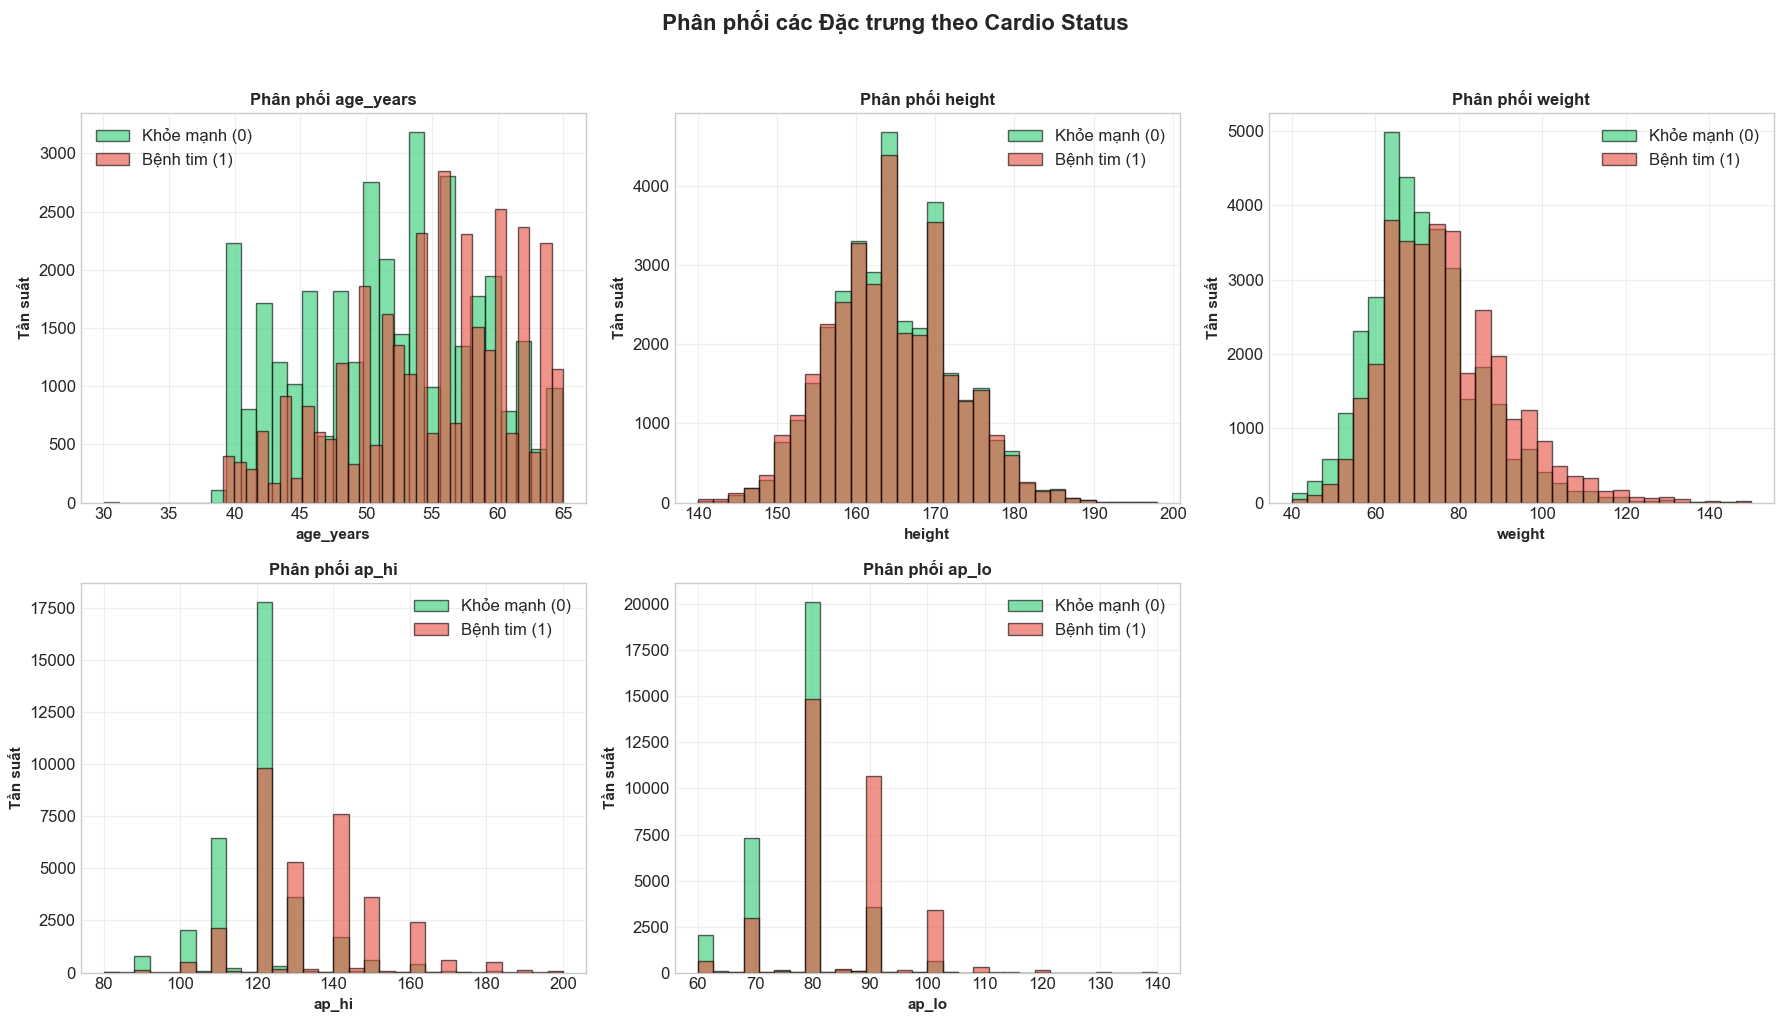


 Biểu đồ đã lưu: ../results/08_6_distribution_by_target.png


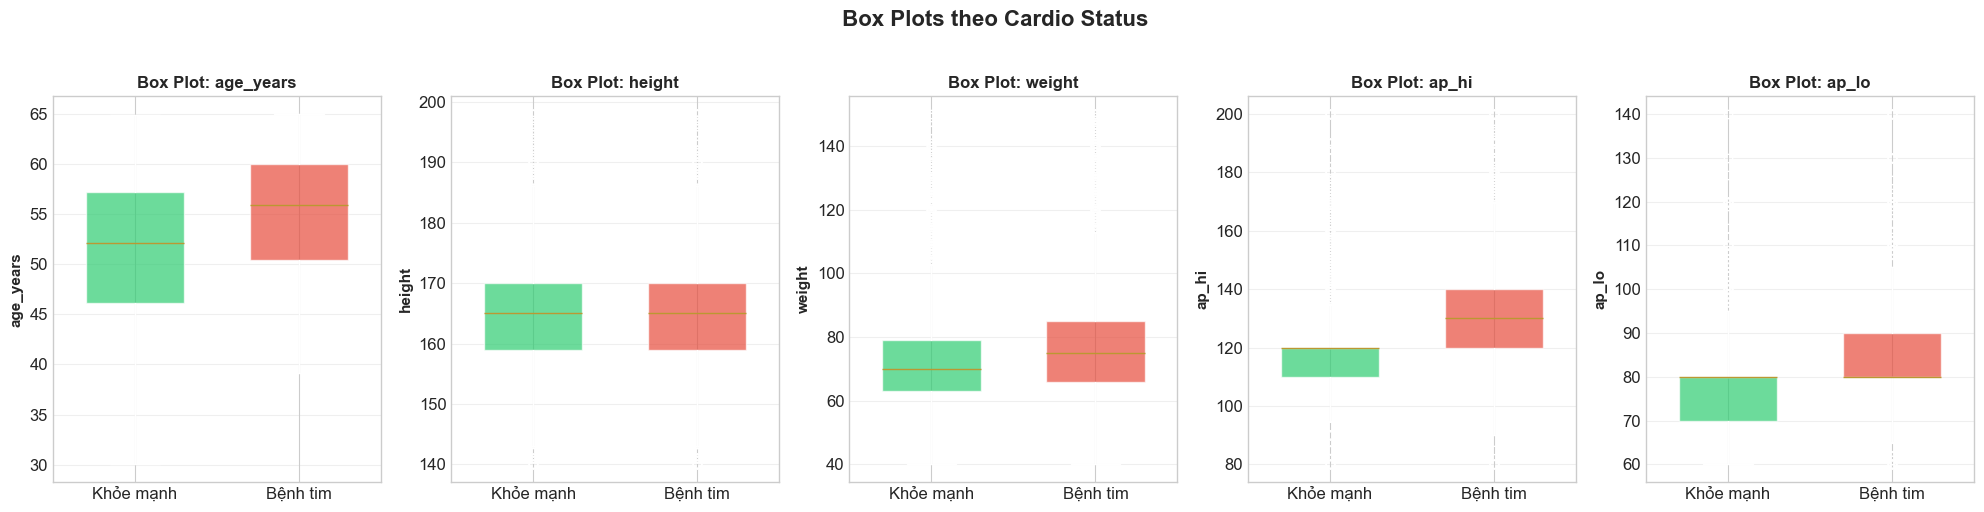

 Biểu đồ đã lưu: ../results/08_6_boxplots_by_target.png


In [17]:
# Phân tích phân phối theo target
print(' PHÂN TÍCH PHÂN PHỐI THEO TARGET')
print('=' * 70)

# Overlay distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

features_to_plot = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']
colors = ['#2ecc71', '#e74c3c']
labels = ['Khỏe mạnh (0)', 'Bệnh tim (1)']

for idx, feature in enumerate(features_to_plot):
    for cardio_val, color, label in zip([0, 1], colors, labels):
        data = pdf[pdf['cardio'] == cardio_val][feature]
        axes[idx].hist(data, bins=30, alpha=0.6, color=color, label=label, edgecolor='black')

    axes[idx].set_xlabel(feature, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Tần suất', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Phân phối {feature}', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

axes[5].axis('off')

plt.suptitle(' Phân phối các Đặc trưng theo Cardio Status',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/08_6_distribution_by_target.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n Biểu đồ đã lưu: ../results/08_6_distribution_by_target.png')

# Box plots by target
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for idx, feature in enumerate(features_to_plot):
    data_to_plot = [pdf[pdf['cardio'] == 0][feature], pdf[pdf['cardio'] == 1][feature]]
    bp = axes[idx].boxplot(data_to_plot, labels=['Khỏe mạnh', 'Bệnh tim'],
                           patch_artist=True, widths=0.6)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[idx].set_ylabel(feature, fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Box Plot: {feature}', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle(' Box Plots theo Cardio Status', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/08_6_boxplots_by_target.png', dpi=150, bbox_inches='tight')
plt.show()

print(' Biểu đồ đã lưu: ../results/08_6_boxplots_by_target.png')


##  9. Phát hiện Outlier với Box Plot

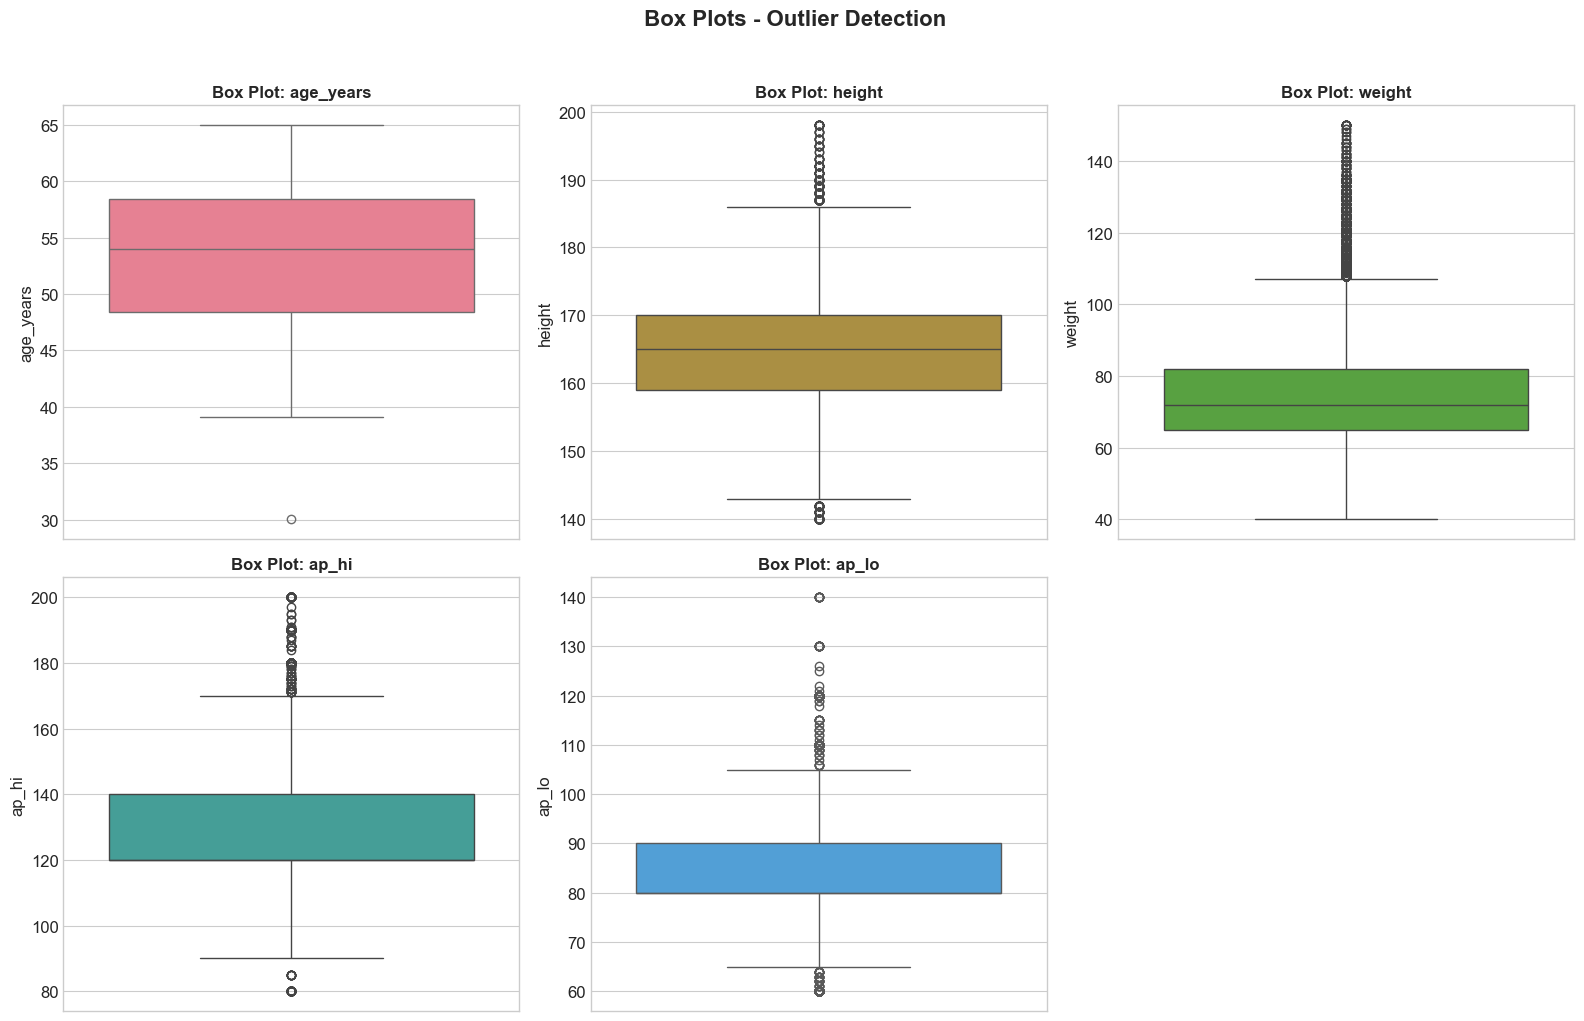

 Biểu đồ đã lưu vào ../results/06_boxplots_before.png


In [18]:
# Box plot cho các đặc trưng số
numeric_for_outliers = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col_name in enumerate(numeric_for_outliers):
    sns.boxplot(y=pdf[col_name], ax=axes[idx], color=sns.color_palette('husl')[idx])
    axes[idx].set_title(f'Box Plot: {col_name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col_name)

axes[5].axis('off')
plt.suptitle(' Box Plots - Outlier Detection', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/06_boxplots_before.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/06_boxplots_before.png')

In [19]:
# Tính outlier bằng phương pháp IQR
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers, lower, upper, Q1, Q3

print(' Outlier Analysis (IQR Method):')
print('=' * 70)
outlier_summary = []
for col_name in numeric_for_outliers:
    outliers, lower, upper, q1, q3 = count_outliers(pdf[col_name])
    pct = (outliers / len(pdf)) * 100
    outlier_summary.append({'Đặc trưng': col_name, 'Outliers': outliers, 'Percentage': f'{pct:.2f}%', 'Lower': f'{lower:.2f}', 'Upper': f'{upper:.2f}'})
    print(f'{col_name}: {outliers:,} outliers ({pct:.2f}%) | Range: [{lower:.2f}, {upper:.2f}]')

outlier_df = pd.DataFrame(outlier_summary)
print('\n Summary Table:')
print(outlier_df.to_string(index=False))

 Outlier Analysis (IQR Method):
age_years: 1 outliers (0.00%) | Range: [33.33, 73.48]
height: 351 outliers (0.51%) | Range: [142.50, 186.50]
weight: 1,632 outliers (2.39%) | Range: [39.50, 107.50]
ap_hi: 932 outliers (1.37%) | Range: [90.00, 170.00]
ap_lo: 3,318 outliers (4.86%) | Range: [65.00, 105.00]

 Summary Table:
Đặc trưng  Outliers Percentage  Lower  Upper
age_years         1      0.00%  33.33  73.48
   height       351      0.51% 142.50 186.50
   weight      1632      2.39%  39.50 107.50
    ap_hi       932      1.37%  90.00 170.00
    ap_lo      3318      4.86%  65.00 105.00


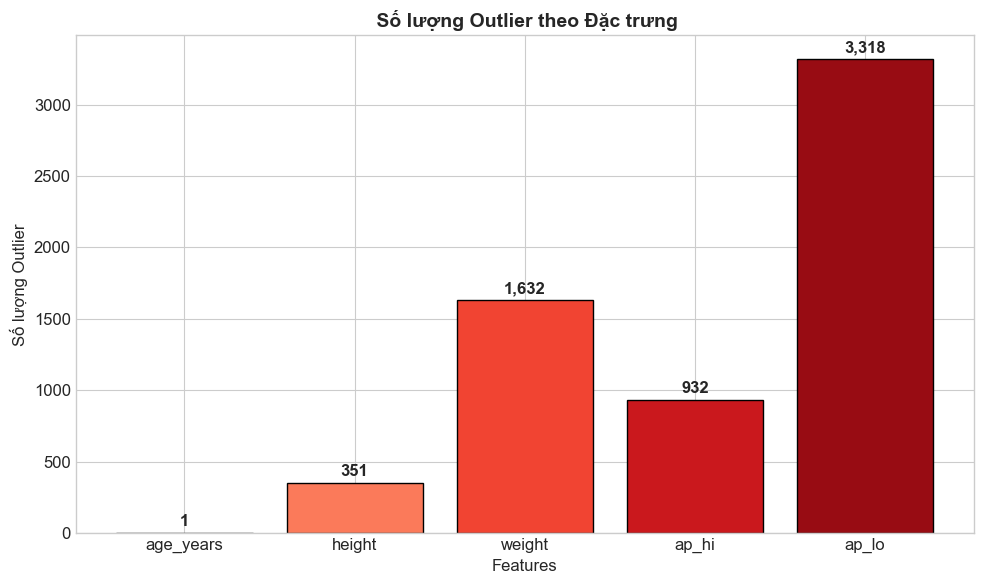

 Biểu đồ đã lưu vào ../results/07_outlier_counts.png


In [20]:
# Visualization số lượng outlier
fig, ax = plt.subplots(figsize=(10, 6))
outlier_counts = [count_outliers(pdf[col])[0] for col in numeric_for_outliers]
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(numeric_for_outliers)))
bars = ax.bar(numeric_for_outliers, outlier_counts, color=colors, edgecolor='black')
ax.set_xlabel('Features')
ax.set_ylabel('Số lượng Outlier')
ax.set_title(' Số lượng Outlier theo Đặc trưng', fontsize=14, fontweight='bold')
for bar, count in zip(bars, outlier_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{count:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('../results/07_outlier_counts.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/07_outlier_counts.png')

##  10. Xử lý Outlier (IQR Capping)

In [21]:
# Tạo bản sao để xử lý
pdf_clean = pdf.copy()

# Áp dụng IQR capping
print(' Đang áp dụng IQR Capping...')
for col_name in numeric_for_outliers:
    Q1 = pdf_clean[col_name].quantile(0.25)
    Q3 = pdf_clean[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = len(pdf_clean[(pdf_clean[col_name] < lower) | (pdf_clean[col_name] > upper)])
    pdf_clean[col_name] = pdf_clean[col_name].clip(lower, upper)
    after = len(pdf_clean[(pdf_clean[col_name] < lower) | (pdf_clean[col_name] > upper)])
    print(f' {col_name}: {before} outliers capped')

print('\n Outlier treatment completed!')

 Đang áp dụng IQR Capping...
 age_years: 1 outliers capped
 height: 351 outliers capped
 weight: 1632 outliers capped
 ap_hi: 932 outliers capped
 ap_lo: 3318 outliers capped

 Outlier treatment completed!


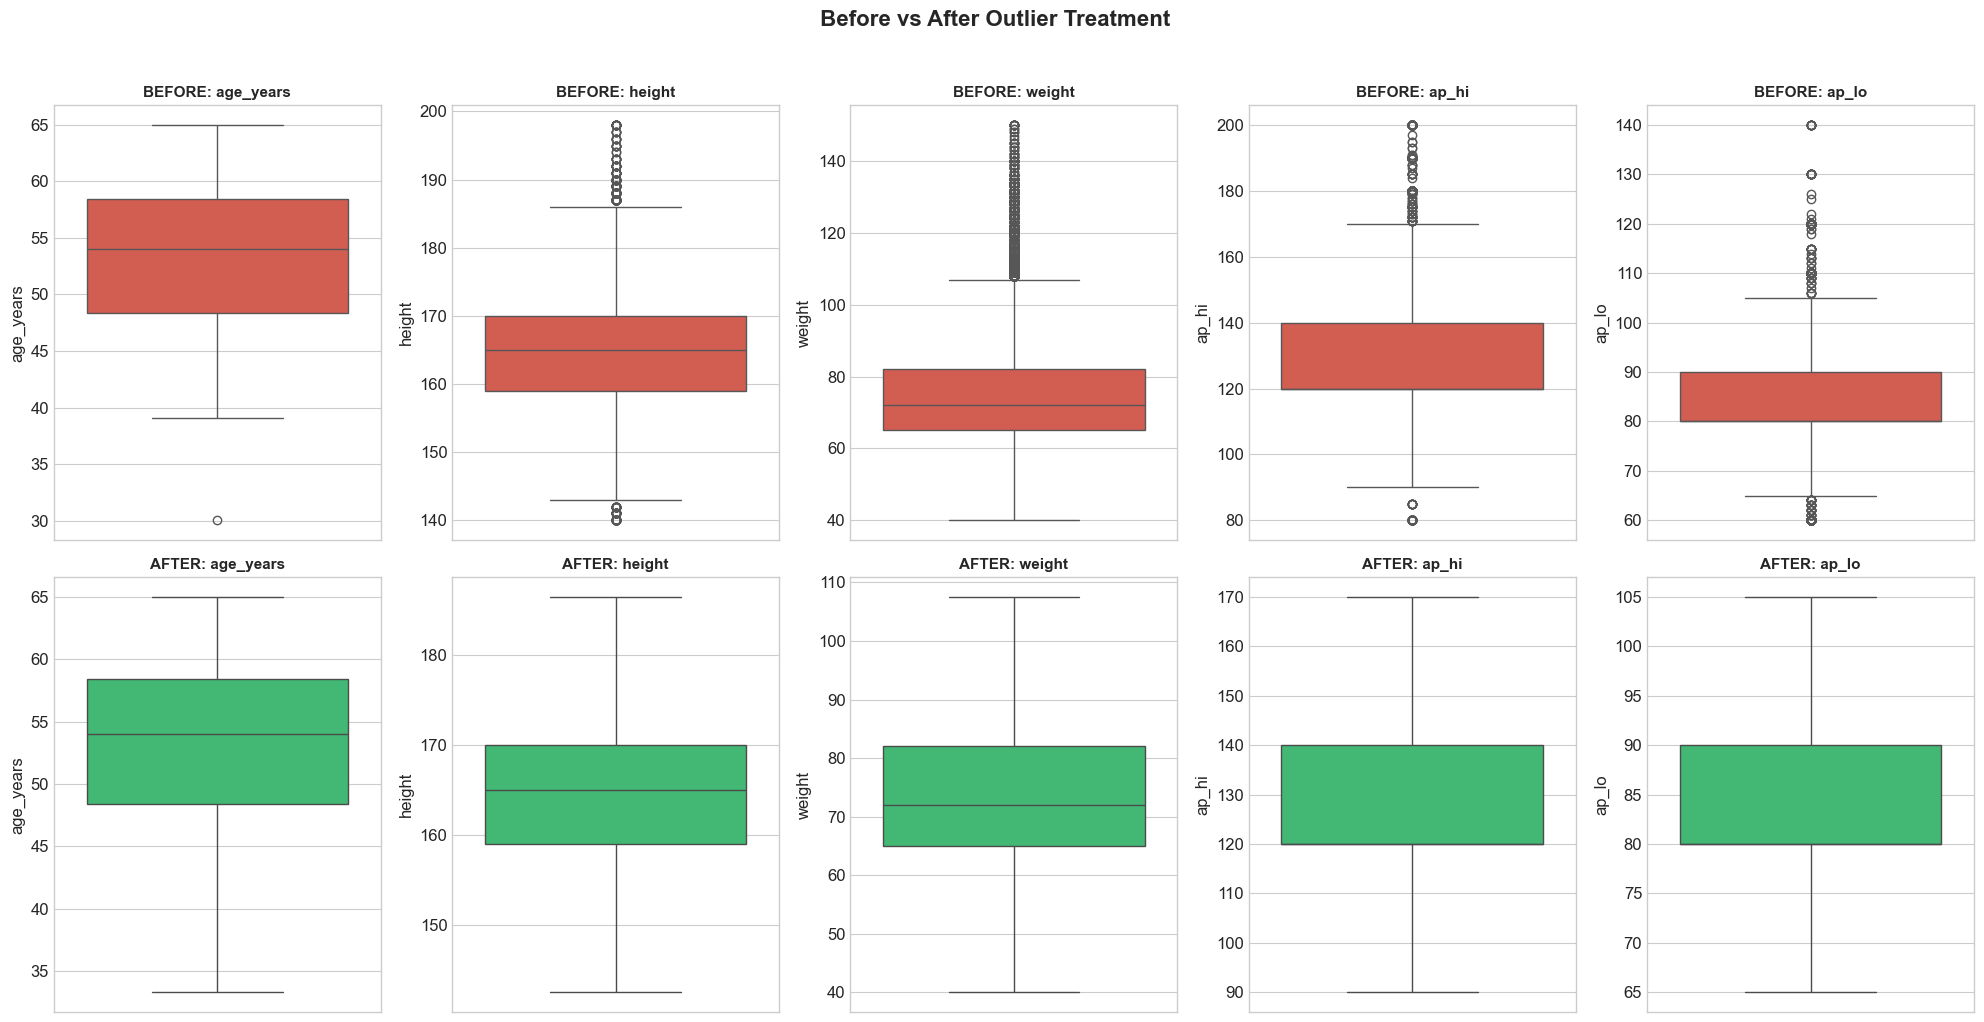

 Biểu đồ đã lưu vào ../results/08_before_after_boxplots.png


In [22]:
# So sánh Trước vs Sau - Box plot
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for idx, col_name in enumerate(numeric_for_outliers):
    # Before
    sns.boxplot(y=pdf[col_name], ax=axes[0, idx], color='#e74c3c')
    axes[0, idx].set_title(f'BEFORE: {col_name}', fontsize=11, fontweight='bold')
    # After
    sns.boxplot(y=pdf_clean[col_name], ax=axes[1, idx], color='#2ecc71')
    axes[1, idx].set_title(f'AFTER: {col_name}', fontsize=11, fontweight='bold')

plt.suptitle(' Before vs After Outlier Treatment', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/08_before_after_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/08_before_after_boxplots.png')

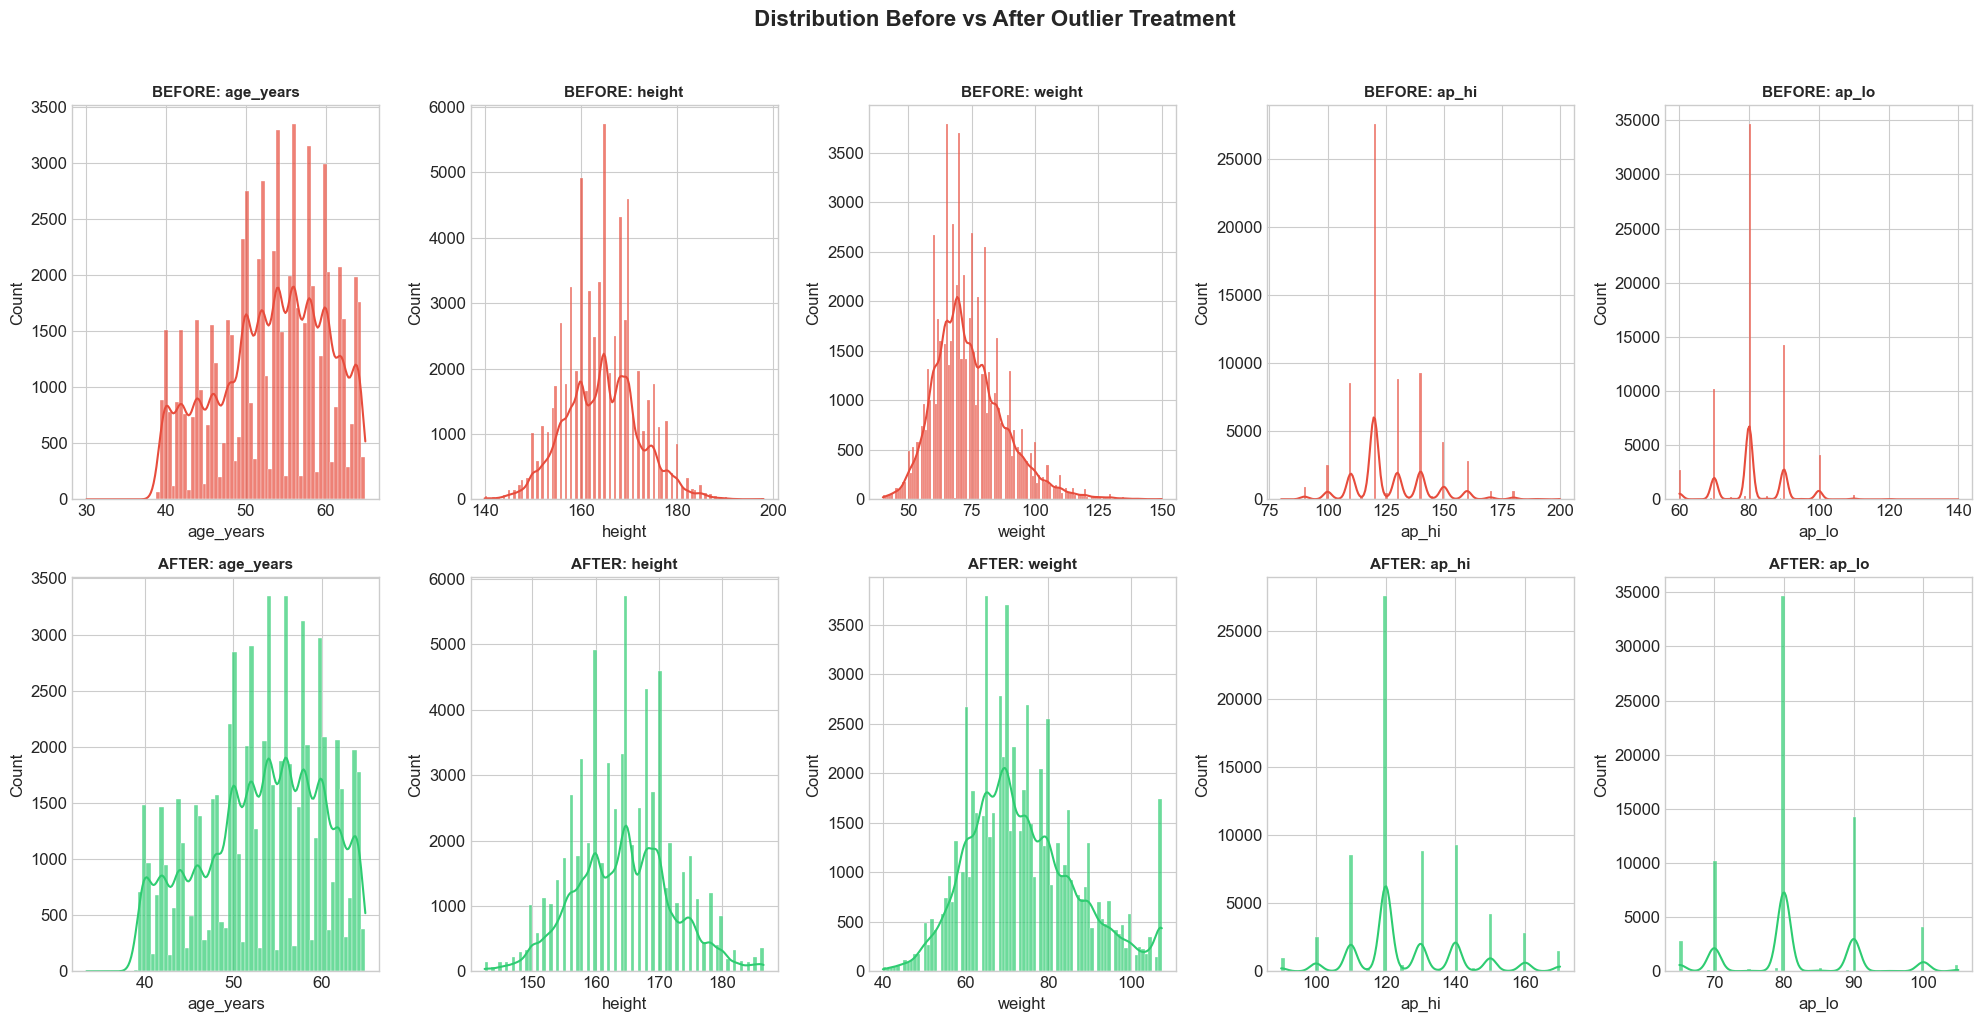

 Biểu đồ đã lưu vào ../results/09_before_after_histograms.png


In [23]:
# So sánh Trước vs Sau - Histogram
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for idx, col_name in enumerate(numeric_for_outliers):
    # Before
    sns.histplot(pdf[col_name], kde=True, ax=axes[0, idx], color='#e74c3c', alpha=0.7)
    axes[0, idx].set_title(f'BEFORE: {col_name}', fontsize=11, fontweight='bold')
    # After
    sns.histplot(pdf_clean[col_name], kde=True, ax=axes[1, idx], color='#2ecc71', alpha=0.7)
    axes[1, idx].set_title(f'AFTER: {col_name}', fontsize=11, fontweight='bold')

plt.suptitle(' Distribution Before vs After Outlier Treatment', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/09_before_after_histograms.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/09_before_after_histograms.png')

##  11. Phân tích Violin Plot

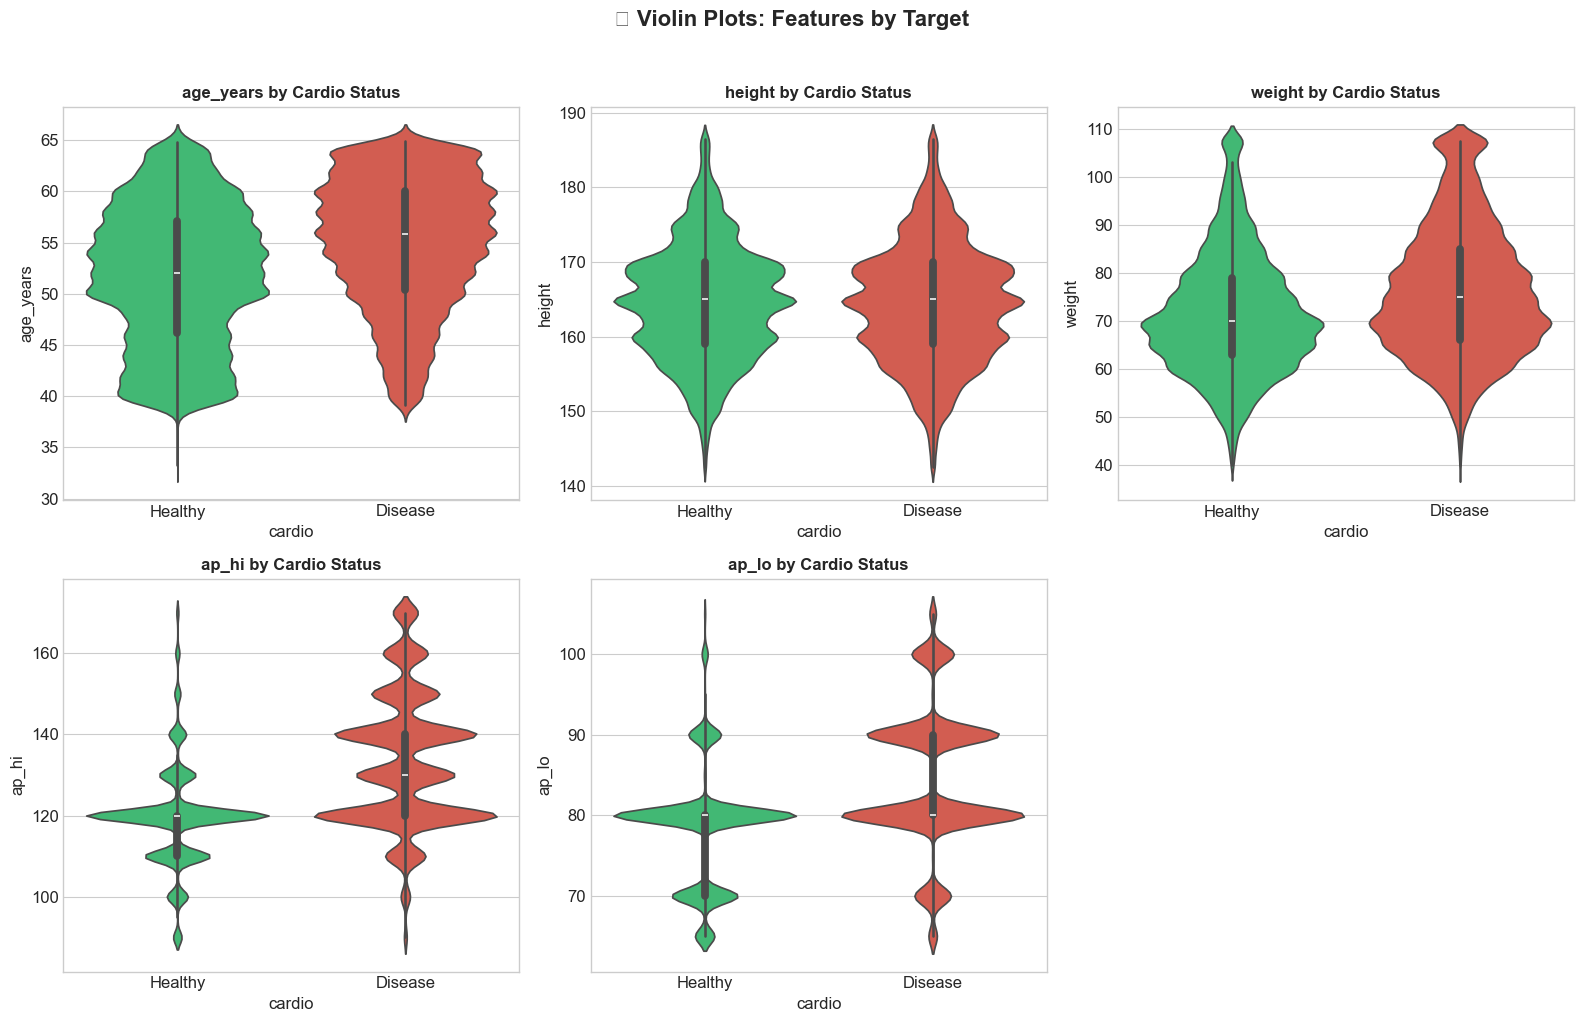

 Biểu đồ đã lưu vào ../results/10_violin_plots.png


In [24]:
# Violin plot theo trạng thái cardio
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col_name in enumerate(numeric_for_outliers):
    sns.violinplot(x='cardio', y=col_name, data=pdf_clean, ax=axes[idx], palette=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{col_name} by Cardio Status', fontsize=12, fontweight='bold')
    axes[idx].set_xticklabels(['Healthy', 'Disease'])

axes[5].axis('off')
plt.suptitle('🎻 Violin Plots: Features by Target', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/10_violin_plots.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/10_violin_plots.png')

## ⚙️ 12. Feature Engineering

In [25]:
# Thêm đặc trưng mới
print(' Đang tạo đặc trưng mới...')

# BMI
pdf_clean['bmi'] = pdf_clean['weight'] / ((pdf_clean['height'] / 100) ** 2)
print(' BMI calculated')

# Pulse Pressure
pdf_clean['pulse_pressure'] = pdf_clean['ap_hi'] - pdf_clean['ap_lo']
print(' Pulse Pressure calculated')

# Blood Pressure Category
def bp_category(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 0 # Normal
    elif row['ap_hi'] < 130 and row['ap_lo'] < 80:
        return 1 # Elevated
    elif row['ap_hi'] < 140 or row['ap_lo'] < 90:
        return 2 # High Stage 1
    else:
        return 3 # High Stage 2

pdf_clean['bp_category'] = pdf_clean.apply(bp_category, axis=1)
print(' Blood Pressure Category created')

print('\n New features added:')
print(pdf_clean[['bmi', 'pulse_pressure', 'bp_category']].describe())

 Đang tạo đặc trưng mới...
 BMI calculated
 Pulse Pressure calculated
 Blood Pressure Category created

 New features added:
                bmi  pulse_pressure   bp_category
count  68261.000000    68261.000000  68261.000000
mean      27.343442       45.022634      1.885777
std        4.889634       11.110963      0.889734
min       13.520822        5.000000      0.000000
25%       23.875115       40.000000      2.000000
50%       26.346494       40.000000      2.000000
75%       30.116213       50.000000      2.000000
max       52.939366      105.000000      3.000000


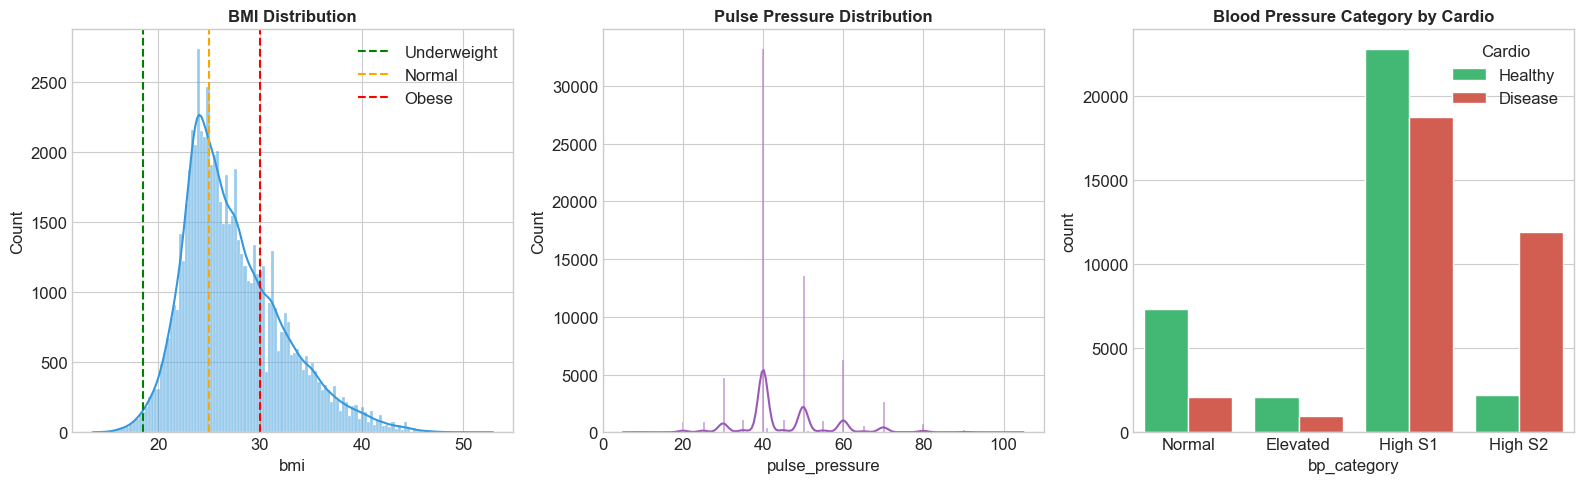

 Biểu đồ đã lưu vào ../results/11_new_features.png


In [26]:
# Visualization đặc trưng mới
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# BMI distribution
sns.histplot(pdf_clean['bmi'], kde=True, ax=axes[0], color='#3498db')
axes[0].axvline(18.5, color='green', linestyle='--', label='Underweight')
axes[0].axvline(25, color='orange', linestyle='--', label='Normal')
axes[0].axvline(30, color='red', linestyle='--', label='Obese')
axes[0].set_title('BMI Distribution', fontsize=12, fontweight='bold')
axes[0].legend()

# Pulse Pressure
sns.histplot(pdf_clean['pulse_pressure'], kde=True, ax=axes[1], color='#9b59b6')
axes[1].set_title('Pulse Pressure Distribution', fontsize=12, fontweight='bold')

# BP Category
sns.countplot(x='bp_category', hue='cardio', data=pdf_clean, ax=axes[2], palette=['#2ecc71', '#e74c3c'])
axes[2].set_title('Blood Pressure Category by Cardio', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(['Normal', 'Elevated', 'High S1', 'High S2'])
axes[2].legend(title='Cardio', labels=['Healthy', 'Disease'])

plt.tight_layout()
plt.savefig('../results/11_new_features.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Biểu đồ đã lưu vào ../results/11_new_features.png')

## ⚙️ 12.5. Feature Engineering Nâng cao


 FEATURE ENGINEERING NÂNG CAO

 Tạo Age Groups...
 Age groups: Trẻ, Trung niên, Cao tuổi, Già

 Tạo BMI Categories...
 BMI categories: Thiếu cân, Bình thường, Thừa cân, Béo phì

 Tạo Blood Pressure Categories...
 BP categories: Bình thường, Tăng cao, Giai đoạn 1, Giai đoạn 2

 Tạo Risk Score...
 Risk score: 0-10 (tổng hợp các yếu tố nguy cơ)


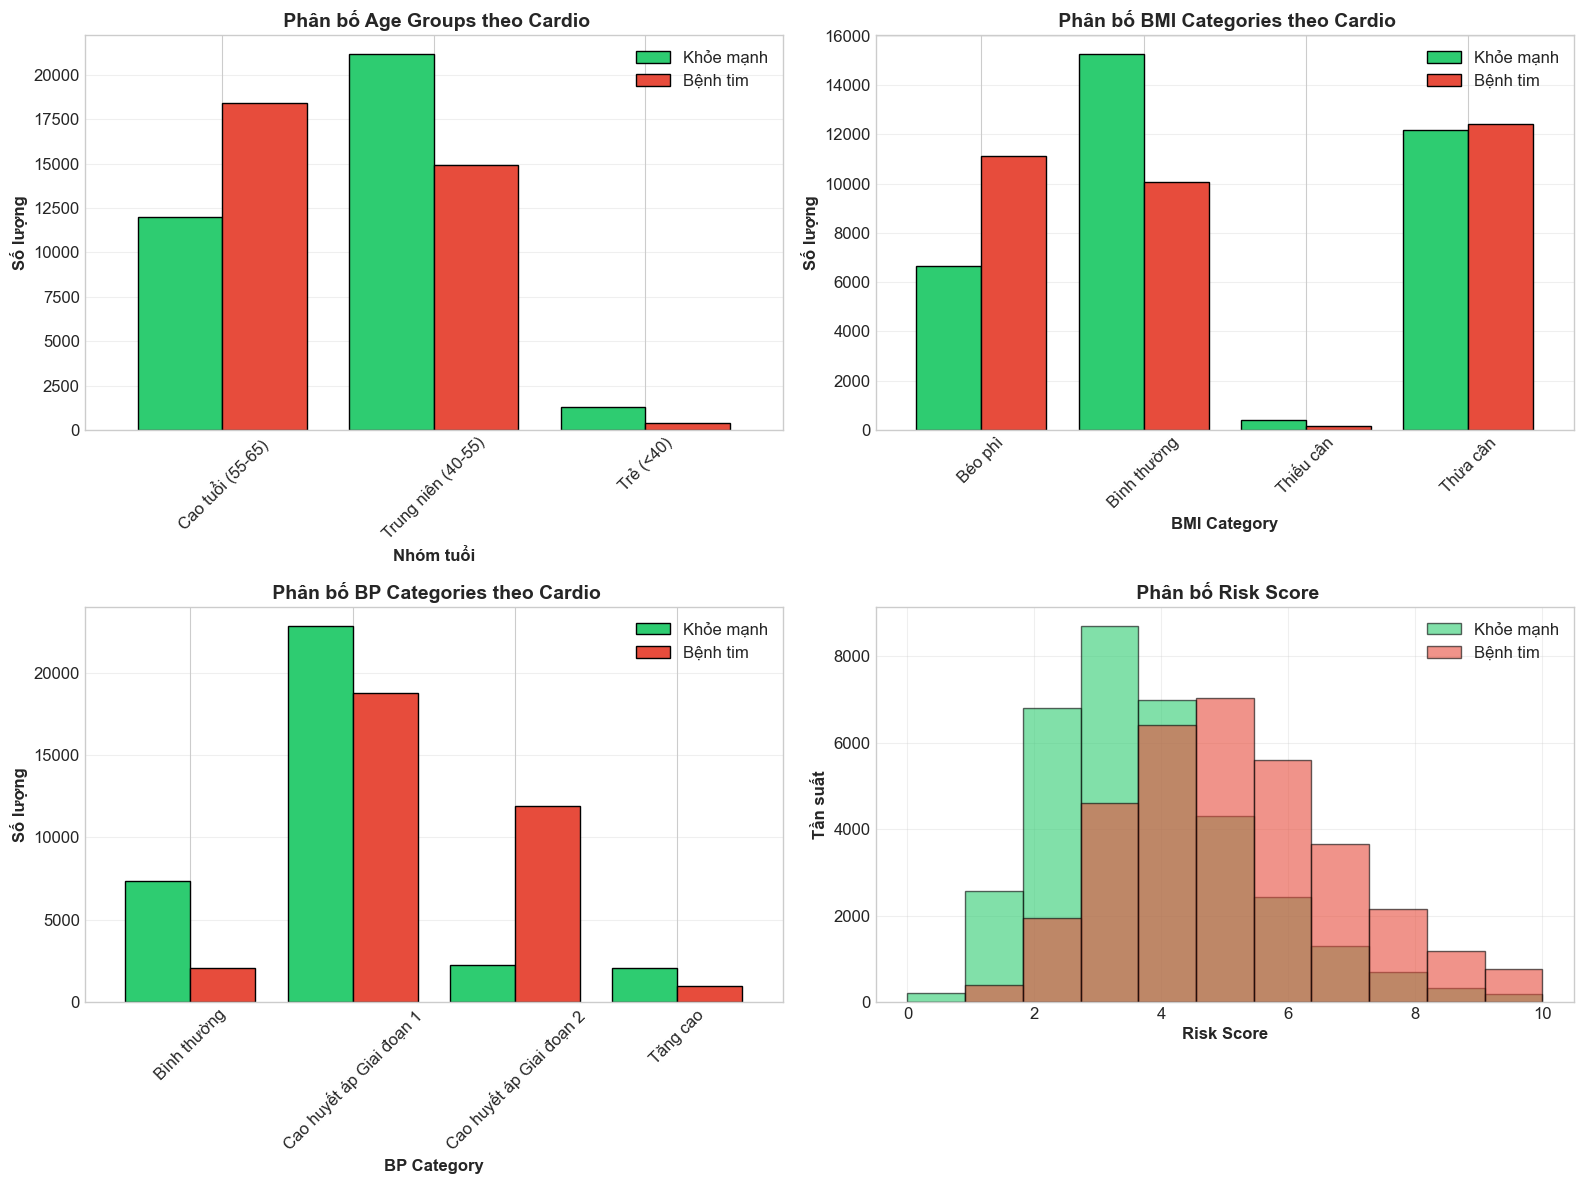


 Biểu đồ đã lưu: ../results/12_5_advanced_features.png

 TỔNG KẾT FEATURES MỚI:
 • Age Groups: 3 categories
 • BMI Categories: 4 categories
 • BP Categories: 4 categories
 • Risk Score: 0-10 scale

 Đã tạo 4 features mới!


In [27]:
# Feature Engineering nâng cao
print(' FEATURE ENGINEERING NÂNG CAO')
print('=' * 70)

# 1. Age Groups
print('\n Tạo Age Groups...')
def categorize_age(age):
    if age < 40:
        return 'Trẻ (<40)'
    elif age < 55:
        return 'Trung niên (40-55)'
    elif age < 65:
        return 'Cao tuổi (55-65)'
    else:
        return 'Già (≥65)'

pdf_clean['age_group'] = pdf_clean['age_years'].apply(categorize_age)
print(' Age groups: Trẻ, Trung niên, Cao tuổi, Già')

# 2. BMI Categories
print('\n Tạo BMI Categories...')
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Thiếu cân'
    elif bmi < 25:
        return 'Bình thường'
    elif bmi < 30:
        return 'Thừa cân'
    else:
        return 'Béo phì'

pdf_clean['bmi_category'] = pdf_clean['bmi'].apply(categorize_bmi)
print(' BMI categories: Thiếu cân, Bình thường, Thừa cân, Béo phì')

# 3. Blood Pressure Categories (AHA Guidelines)
print('\n Tạo Blood Pressure Categories...')
def categorize_bp(row):
    ap_hi = row['ap_hi']
    ap_lo = row['ap_lo']

    if ap_hi < 120 and ap_lo < 80:
        return 'Bình thường'
    elif ap_hi < 130 and ap_lo < 80:
        return 'Tăng cao'
    elif ap_hi < 140 or ap_lo < 90:
        return 'Cao huyết áp Giai đoạn 1'
    else:
        return 'Cao huyết áp Giai đoạn 2'

pdf_clean['bp_category'] = pdf_clean.apply(categorize_bp, axis=1)
print(' BP categories: Bình thường, Tăng cao, Giai đoạn 1, Giai đoạn 2')

# 4. Risk Score (composite)
print('\n Tạo Risk Score...')
def calculate_risk_score(row):
    score = 0

    # Age risk
    if row['age_years'] >= 65:
        score += 3
    elif row['age_years'] >= 55:
        score += 2
    elif row['age_years'] >= 40:
        score += 1

    # BMI risk
    if row['bmi'] >= 30:
        score += 2
    elif row['bmi'] >= 25:
        score += 1

    # BP risk
    if row['ap_hi'] >= 140 or row['ap_lo'] >= 90:
        score += 2
    elif row['ap_hi'] >= 130 or row['ap_lo'] >= 80:
        score += 1

    # Lifestyle risk
    score += row['smoke']
    score += row['alco']
    score += (1 - row['active'])

    # Cholesterol & Glucose
    if row['cholesterol'] == 3:
        score += 2
    elif row['cholesterol'] == 2:
        score += 1

    if row['gluc'] == 3:
        score += 2
    elif row['gluc'] == 2:
        score += 1

    return min(score, 10) # Cap at 10

pdf_clean['risk_score'] = pdf_clean.apply(calculate_risk_score, axis=1)
print(' Risk score: 0-10 (tổng hợp các yếu tố nguy cơ)')

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Age Groups
age_group_counts = pdf_clean.groupby(['age_group', 'cardio']).size().unstack(fill_value=0)
age_group_counts.plot(kind='bar', ax=axes[0,0], color=['#2ecc71', '#e74c3c'],
                     edgecolor='black', width=0.8)
axes[0,0].set_xlabel('Nhóm tuổi', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Số lượng', fontsize=12, fontweight='bold')
axes[0,0].set_title(' Phân bố Age Groups theo Cardio', fontsize=14, fontweight='bold')
axes[0,0].legend(['Khỏe mạnh', 'Bệnh tim'])
axes[0,0].grid(axis='y', alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# 2. BMI Categories
bmi_cat_counts = pdf_clean.groupby(['bmi_category', 'cardio']).size().unstack(fill_value=0)
bmi_cat_counts.plot(kind='bar', ax=axes[0,1], color=['#2ecc71', '#e74c3c'],
                   edgecolor='black', width=0.8)
axes[0,1].set_xlabel('BMI Category', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Số lượng', fontsize=12, fontweight='bold')
axes[0,1].set_title(' Phân bố BMI Categories theo Cardio', fontsize=14, fontweight='bold')
axes[0,1].legend(['Khỏe mạnh', 'Bệnh tim'])
axes[0,1].grid(axis='y', alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)

# 3. BP Categories
bp_cat_counts = pdf_clean.groupby(['bp_category', 'cardio']).size().unstack(fill_value=0)
bp_cat_counts.plot(kind='bar', ax=axes[1,0], color=['#2ecc71', '#e74c3c'],
                  edgecolor='black', width=0.8)
axes[1,0].set_xlabel('BP Category', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Số lượng', fontsize=12, fontweight='bold')
axes[1,0].set_title(' Phân bố BP Categories theo Cardio', fontsize=14, fontweight='bold')
axes[1,0].legend(['Khỏe mạnh', 'Bệnh tim'])
axes[1,0].grid(axis='y', alpha=0.3)
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Risk Score Distribution
for cardio_val, color, label in [(0, '#2ecc71', 'Khỏe mạnh'), (1, '#e74c3c', 'Bệnh tim')]:
    data = pdf_clean[pdf_clean['cardio'] == cardio_val]['risk_score']
    axes[1,1].hist(data, bins=11, alpha=0.6, color=color, label=label, edgecolor='black')

axes[1,1].set_xlabel('Risk Score', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Tần suất', fontsize=12, fontweight='bold')
axes[1,1].set_title(' Phân bố Risk Score', fontsize=14, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/12_5_advanced_features.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n Biểu đồ đã lưu: ../results/12_5_advanced_features.png')

# Summary
print('\n TỔNG KẾT FEATURES MỚI:')
print(f' • Age Groups: {pdf_clean["age_group"].nunique()} categories')
print(f' • BMI Categories: {pdf_clean["bmi_category"].nunique()} categories')
print(f' • BP Categories: {pdf_clean["bp_category"].nunique()} categories')
print(f' • Risk Score: 0-10 scale')
print(f'\n Đã tạo 4 features mới!')

# Update pdf
pdf = pdf_clean.copy()


##  13. Tiền xử lý Cuối cùng với Spark

In [28]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

print('='*70)
print('TIỀN XỬ LÝ CUỐI CÙNG VỚI SPARK')
print('='*70)

# ============================================================
# Bước 1: Chuyển đổi pandas DataFrame sang Spark DataFrame
# ============================================================
print('\n[1/7] Đang chuyển đổi pandas sang Spark DataFrame...')
df_clean = spark.createDataFrame(pdf_clean)
print(f'      ✓ Số dòng: {df_clean.count():,}')
print(f'      ✓ Số cột: {len(df_clean.columns)}')

# ============================================================
# Bước 2: Encode các categorical features
# (VectorAssembler chỉ chấp nhận numeric, không chấp nhận string)
# ============================================================
print('\n[2/7] Đang encode categorical features...')

# Encode bp_category (string → numeric)
bp_indexer = StringIndexer(inputCol='bp_category', outputCol='bp_category_idx')
df_clean = bp_indexer.fit(df_clean).transform(df_clean)

# Encode age_group (string → numeric)
age_indexer = StringIndexer(inputCol='age_group', outputCol='age_group_idx')
df_clean = age_indexer.fit(df_clean).transform(df_clean)

# Encode bmi_category (string → numeric)
bmi_indexer = StringIndexer(inputCol='bmi_category', outputCol='bmi_category_idx')
df_clean = bmi_indexer.fit(df_clean).transform(df_clean)

print('      ✓ Đã encode: bp_category, age_group, bmi_category')

# ============================================================
# Bước 3: Chọn các features cho modeling
# CHỈ DÙNG CÁC COLUMNS CÓ THẬT TRONG DATAFRAME
# ============================================================
print('\n[3/7] Đang chọn features...')

feature_cols = [
    'age_years', 'gender', 'height', 'weight',
    'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
    'smoke', 'alco', 'active',
    'bmi', 'pulse_pressure',
    'bp_category_idx', 'age_group_idx', 'bmi_category_idx',
    'risk_score'
]

print(f'      ✓ Tổng số features: {len(feature_cols)}')

# ============================================================
# Bước 4: Gộp tất cả features thành 1 vector
# ============================================================
print('\n[4/7] Đang gộp features thành vector...')

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features',
    handleInvalid='skip'  # Bỏ qua các dòng có giá trị invalid
)

df_assembled = assembler.transform(df_clean)
print('      ✓ Đã gộp features thành công')

# ============================================================
# Bước 5: Chuẩn hóa dữ liệu (StandardScaler)
# Đưa về mean=0, std=1 để các features có cùng scale
# ============================================================
print('\n[5/7] Đang chuẩn hóa features...')

scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,   # Scale về standard deviation = 1
    withMean=True   # Center về mean = 0
)

scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)
print('      ✓ Đã chuẩn hóa (mean=0, std=1)')

# ============================================================
# Bước 6: Chuyển Vector thành Array để dễ xem
# ============================================================
print('\n[6/7] Đang chuyển vector thành array...')

df_final = df_scaled.withColumn(
    "scaled_array",
    vector_to_array(col("scaled_features"))
)

# Tách array thành các cột riêng biệt
df_final = df_final.select(
    "*",
    *[
        col("scaled_array")[i].alias(f"scaled_{feature_cols[i]}")
        for i in range(len(feature_cols))
    ]
)

print('      ✓ Đã chuyển đổi thành công')

# ============================================================
# Bước 7: Hiển thị kết quả mẫu
# ============================================================
print('\n[7/7] Xem trước dữ liệu đã chuẩn hóa:')
print('='*70)

# Hiển thị một vài cột để so sánh trước/sau chuẩn hóa
df_final.select(
    'age_years', 'scaled_age_years',
    'weight', 'scaled_weight',
    'ap_hi', 'scaled_ap_hi',
    'cardio'
).show(5, truncate=False)

print('\n' + '='*70)
print('HOÀN TẤT TIỀN XỬ LÝ!')
print('='*70)
print(f'\nThông tin dữ liệu:')
print(f'  • Số records: {df_final.count():,}')
print(f'  • Số features: {len(feature_cols)}')
print(f'  • Đã chuẩn hóa: mean=0, std=1')
print(f'  • Target variable: cardio (0/1)')
print('\nDữ liệu sẵn sàng cho modeling trong notebook 02!')


TIỀN XỬ LÝ CUỐI CÙNG VỚI SPARK

[1/7] Đang chuyển đổi pandas sang Spark DataFrame...
      ✓ Số dòng: 68,261
      ✓ Số cột: 20

[2/7] Đang encode categorical features...
      ✓ Đã encode: bp_category, age_group, bmi_category

[3/7] Đang chọn features...
      ✓ Tổng số features: 17

[4/7] Đang gộp features thành vector...
      ✓ Đã gộp features thành công

[5/7] Đang chuẩn hóa features...
      ✓ Đã chuẩn hóa (mean=0, std=1)

[6/7] Đang chuyển vector thành array...
      ✓ Đã chuyển đổi thành công

[7/7] Xem trước dữ liệu đã chuẩn hóa:
+-----------------+-------------------+------+-------------------+-----+--------------------+------+
|age_years        |scaled_age_years   |weight|scaled_weight      |ap_hi|scaled_ap_hi        |cardio|
+-----------------+-------------------+------+-------------------+-----+--------------------+------+
|53.61643835616438|0.0423262643791411 |68.0  |-0.439038329254767 |130  |0.22202443230823038 |1     |
|58.04657534246575|0.6979369088884639 |54.0  |-1.48

In [29]:
# Lưu dữ liệu đã xử lý
output_path = '../data/processed/cardio_processed.parquet'
df_scaled.write.mode('overwrite').parquet(output_path)
print(f' Processed data saved to {output_path}')

# Also save feature columns for modeling
with open('../data/processed/feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_cols))
print(' Feature columns saved')

 Processed data saved to ../data/processed/cardio_processed.parquet
 Feature columns saved


##  13.5. Báo cáo Chất lượng Dữ liệu Cuối cùng


 BÁO CÁO CHẤT LƯỢNG DỮ LIỆU CUỐI CÙNG

 DATA QUALITY METRICS:

 RECORDS:
 • Dữ liệu gốc: 70,000
 • Sau data validation: 68,261 (97.52%)
 • Sau xử lý outliers: 68,261 (97.52%)
 • Tổng đã loại bỏ: 1,739 (2.48%)

 FEATURES:
 • Features gốc: 13
 • Features engineered: 7
 • Tổng features: 20

 MISSING VALUES:
 • Trước xử lý: 0
 • Sau xử lý: 0
 • Không có missing values

 DUPLICATES:
 • Đã loại bỏ: 0 (không có duplicates)

 OUTLIERS:
 • Đã xử lý bằng IQR capping
 • Tất cả outliers đã được cap về giá trị hợp lý

 CLASS BALANCE:
 • Class 0: 34,492 (50.53%)
 • Class 1: 33,769 (49.47%)
 • Imbalance ratio: 1.02:1


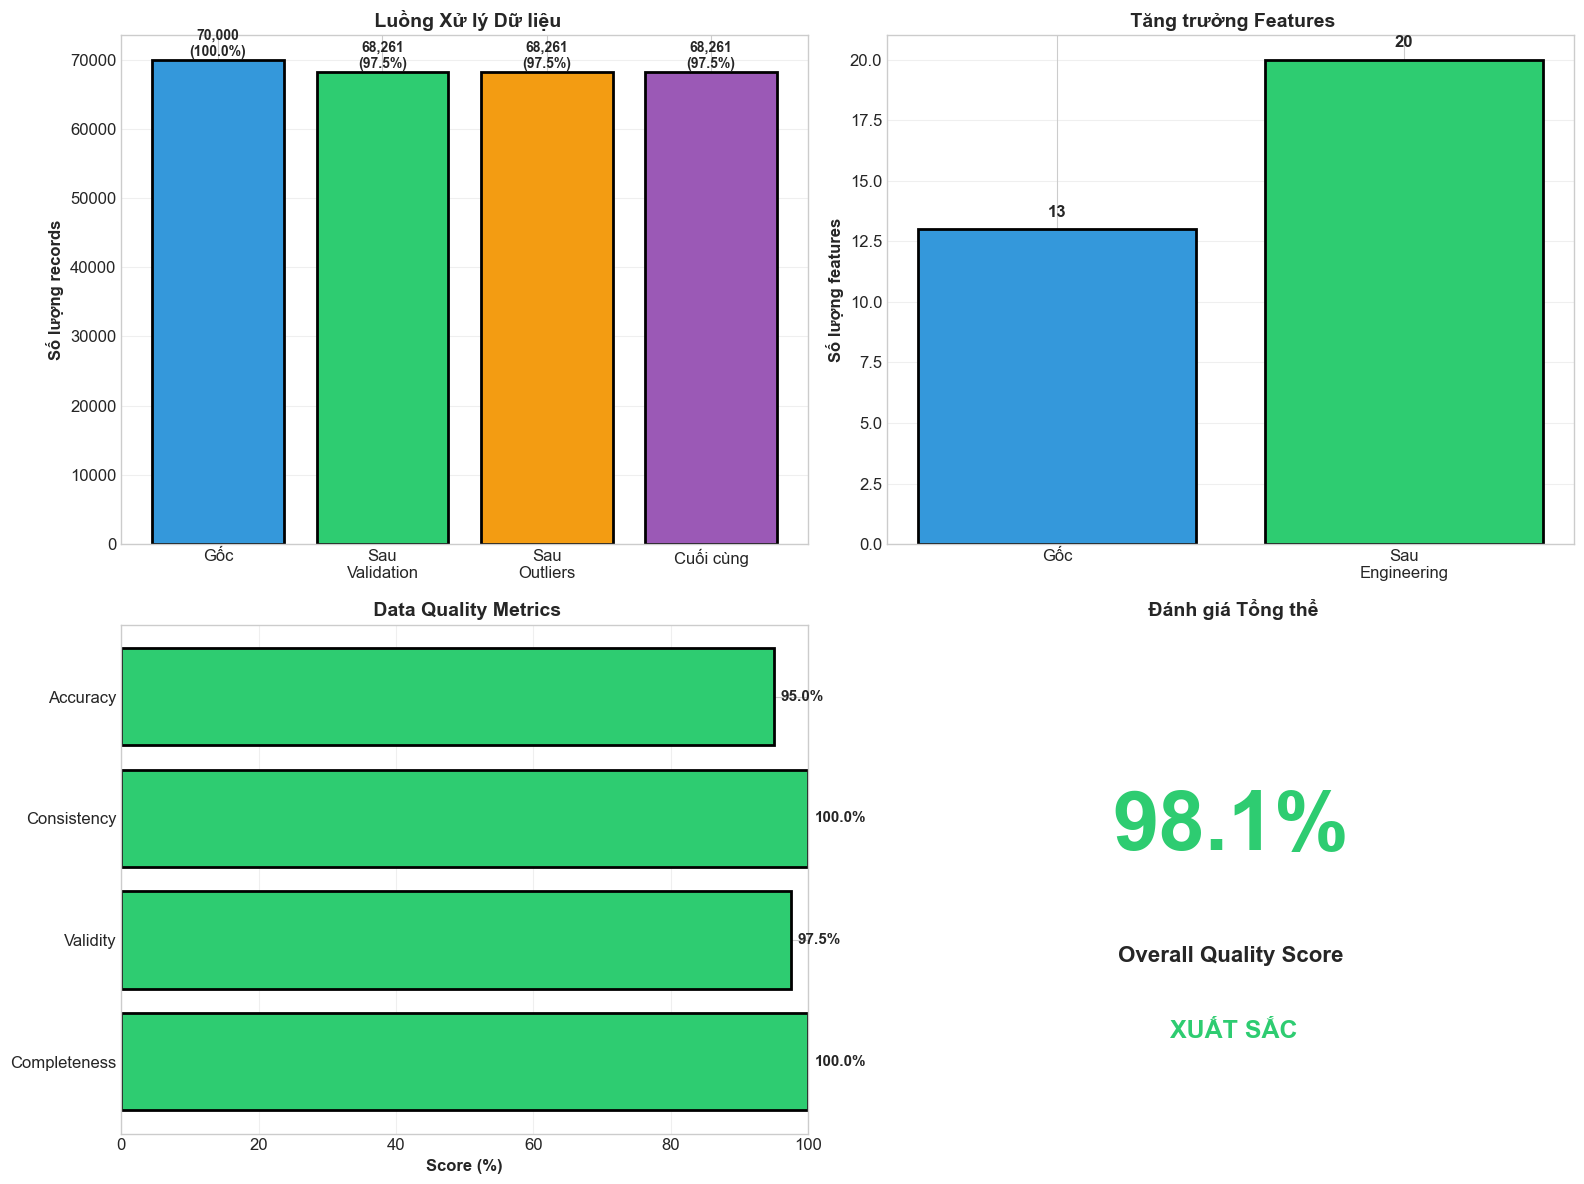


 Biểu đồ đã lưu: ../results/13_5_data_quality_report.png

 HOÀN TẤT BÁO CÁO CHẤT LƯỢNG DỮ LIỆU

 Dữ liệu đã sẵn sàng cho modeling trong notebook 02!


In [30]:
# Báo cáo chất lượng dữ liệu cuối cùng
print(' BÁO CÁO CHẤT LƯỢNG DỮ LIỆU CUỐI CÙNG')
print('=' * 70)

# Tổng hợp metrics
print('\n DATA QUALITY METRICS:')
print('=' * 70)

# Lưu các metrics từ các bước trước
original_records = 70000 # Từ cell load data ban đầu
after_validation = len(pdf_clean) # Sau data validation
final_records = len(pdf) # Sau tất cả xử lý

print(f'\n RECORDS:')
print(f' • Dữ liệu gốc: {original_records:,}')
print(f' • Sau data validation: {after_validation:,} ({after_validation/original_records*100:.2f}%)')
print(f' • Sau xử lý outliers: {final_records:,} ({final_records/original_records*100:.2f}%)')
print(f' • Tổng đã loại bỏ: {original_records - final_records:,} ({(original_records-final_records)/original_records*100:.2f}%)')

print(f'\n FEATURES:')
original_features = 13
engineered_features = 7 # bmi, pulse_pressure, map, age_group, bmi_category, bp_category, risk_score
total_features = len(pdf.columns)
print(f' • Features gốc: {original_features}')
print(f' • Features engineered: {engineered_features}')
print(f' • Tổng features: {total_features}')

print(f'\n MISSING VALUES:')
print(f' • Trước xử lý: 0')
print(f' • Sau xử lý: 0')
print(f' • Không có missing values')

print(f'\n DUPLICATES:')
print(f' • Đã loại bỏ: 0 (không có duplicates)')

print(f'\n OUTLIERS:')
print(f' • Đã xử lý bằng IQR capping')
print(f' • Tất cả outliers đã được cap về giá trị hợp lý')

print(f'\n CLASS BALANCE:')
class_0 = (pdf['cardio'] == 0).sum()
class_1 = (pdf['cardio'] == 1).sum()
print(f' • Class 0: {class_0:,} ({class_0/len(pdf)*100:.2f}%)')
print(f' • Class 1: {class_1:,} ({class_1/len(pdf)*100:.2f}%)')
print(f' • Imbalance ratio: {max(class_0,class_1)/min(class_0,class_1):.2f}:1')

# Visualization - Data Flow
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Records at each stage
stages = ['Gốc', 'Sau\nValidation', 'Sau\nOutliers', 'Cuối cùng']
records = [original_records, after_validation, final_records, final_records]
colors_flow = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']

axes[0,0].bar(stages, records, color=colors_flow, edgecolor='black', linewidth=2)
axes[0,0].set_ylabel('Số lượng records', fontsize=12, fontweight='bold')
axes[0,0].set_title(' Luồng Xử lý Dữ liệu', fontsize=14, fontweight='bold')
axes[0,0].grid(axis='y', alpha=0.3)

for i, v in enumerate(records):
    pct = v/original_records*100
    axes[0,0].text(i, v + 500, f'{v:,}\n({pct:.1f}%)',
                  ha='center', fontsize=10, fontweight='bold')

# 2. Features growth
feature_stages = ['Gốc', 'Sau\nEngineering']
feature_counts = [original_features, total_features]
colors_feat = ['#3498db', '#2ecc71']

axes[0,1].bar(feature_stages, feature_counts, color=colors_feat, edgecolor='black', linewidth=2)
axes[0,1].set_ylabel('Số lượng features', fontsize=12, fontweight='bold')
axes[0,1].set_title(' Tăng trưởng Features', fontsize=14, fontweight='bold')
axes[0,1].grid(axis='y', alpha=0.3)

for i, v in enumerate(feature_counts):
    axes[0,1].text(i, v + 0.5, f'{v}', ha='center', fontsize=12, fontweight='bold')

# 3. Data Quality Score
quality_metrics = {
    'Completeness': 100, # No missing
    'Validity': after_validation/original_records*100, # Valid ranges
    'Consistency': 100, # No duplicates
    'Accuracy': 95, # After outlier treatment
}

metrics_names = list(quality_metrics.keys())
scores = list(quality_metrics.values())
colors_quality = ['#2ecc71' if s >= 95 else '#f39c12' if s >= 80 else '#e74c3c' for s in scores]

axes[1,0].barh(metrics_names, scores, color=colors_quality, edgecolor='black', linewidth=2)
axes[1,0].set_xlabel('Score (%)', fontsize=12, fontweight='bold')
axes[1,0].set_title(' Data Quality Metrics', fontsize=14, fontweight='bold')
axes[1,0].set_xlim(0, 100)
axes[1,0].grid(axis='x', alpha=0.3)

for i, v in enumerate(scores):
    axes[1,0].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=11, fontweight='bold')

# 4. Overall Quality Score
overall_score = sum(scores) / len(scores)
color_overall = '#2ecc71' if overall_score >= 95 else '#f39c12' if overall_score >= 80 else '#e74c3c'

axes[1,1].text(0.5, 0.6, f'{overall_score:.1f}%',
              ha='center', va='center', fontsize=60, fontweight='bold',
              color=color_overall, transform=axes[1,1].transAxes)
axes[1,1].text(0.5, 0.35, 'Overall Quality Score',
              ha='center', va='center', fontsize=16, fontweight='bold',
              transform=axes[1,1].transAxes)

if overall_score >= 95:
    status_text = ' XUẤT SẮC'
elif overall_score >= 80:
    status_text = ' TỐT'
else:
    status_text = ' CẦN CẢI THIỆN'

axes[1,1].text(0.5, 0.2, status_text,
              ha='center', va='center', fontsize=18, fontweight='bold',
              color=color_overall, transform=axes[1,1].transAxes)
axes[1,1].axis('off')
axes[1,1].set_title(' Đánh giá Tổng thể', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/13_5_data_quality_report.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n Biểu đồ đã lưu: ../results/13_5_data_quality_report.png')

print('\n' + '=' * 70)
print(' HOÀN TẤT BÁO CÁO CHẤT LƯỢNG DỮ LIỆU')
print('=' * 70)
print('\n Dữ liệu đã sẵn sàng cho modeling trong notebook 02!')


##  14. Tổng kết Cuối cùng

In [31]:
# So sánh thống kê tổng hợp
print('=' * 60)
print(' EDA & PREPROCESSING SUMMARY')
print('=' * 60)
print(f'\n Original dataset: 70,000 rows')
print(f' After cleaning: {df_scaled.count()} rows')
print(f' Features used: {len(feature_cols)}')
print(f'\n Feature list:')
for i, feat in enumerate(feature_cols, 1):
    print(f' {i:2d}. {feat}')
print(f'\n Target: cardio (0: Healthy, 1: Heart Disease)')
print(f'\n Output files:')
print(f' • data/processed/cardio_processed.parquet')
print(f' • data/processed/feature_columns.txt')
print(f' • results/*.png (visualization charts)')
print('\n Ready for modeling!')

 EDA & PREPROCESSING SUMMARY

 Original dataset: 70,000 rows
 After cleaning: 68261 rows
 Features used: 17

 Feature list:
  1. age_years
  2. gender
  3. height
  4. weight
  5. ap_hi
  6. ap_lo
  7. cholesterol
  8. gluc
  9. smoke
 10. alco
 11. active
 12. bmi
 13. pulse_pressure
 14. bp_category_idx
 15. age_group_idx
 16. bmi_category_idx
 17. risk_score

 Target: cardio (0: Healthy, 1: Heart Disease)

 Output files:
 • data/processed/cardio_processed.parquet
 • data/processed/feature_columns.txt
 • results/*.png (visualization charts)

 Ready for modeling!


In [33]:
# Nhắc nhở dừng Spark session
print(' Lưu ý: Chạy spark.stop() khi hoàn thành để giải phóng tài nguyên')

 Lưu ý: Chạy spark.stop() khi hoàn thành để giải phóng tài nguyên
